In [ ]:
pip install segmentation_models_3D
pip install tensorflow-addons
pip install SimpleITK
pip install medpy

In [3]:
import tensorflow as tf
print("Num GPUs Available: " , len(tf.config.experimental.list_physical_devices('GPU')))

Num GPUs Available:  1


In [4]:
#Code can be divided into a few parts....
#1-Combine
#2-Changing mask pixel values (labels) from 4 to 3 (as the original labels are 0, 1, 2, 4)
#3-Visualize

In [11]:
import numpy as np
import nibabel as nib
import os
import glob
#from tensorflow.keras.utils import to_categorical
import matplotlib.pyplot as plt
from tifffile import imsave
from sklearn.preprocessing import MinMaxScaler

In [12]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import pandas as pd
root = '/content/drive/MyDrive/Bratsdataset/BraTs2020_TrainingData/MICCAI_BraTS2020_TrainingData'
data = pd.read_csv('/content/drive/MyDrive/Bratsdataset/name_mapping.csv')
data.head(5)

Grade BraTS_2017_subject_ID BraTS_2018_subject_ID TCGA_TCIA_subject_ID  \
0   HGG   Brats17_CBICA_AAB_1   Brats18_CBICA_AAB_1                  NaN   
1   HGG   Brats17_CBICA_AAG_1   Brats18_CBICA_AAG_1                  NaN   
2   HGG   Brats17_CBICA_AAL_1   Brats18_CBICA_AAL_1                  NaN   
3   HGG   Brats17_CBICA_AAP_1   Brats18_CBICA_AAP_1                  NaN   
4   HGG   Brats17_CBICA_ABB_1   Brats18_CBICA_ABB_1                  NaN   

  BraTS_2019_subject_ID BraTS_2020_subject_ID  
0   BraTS19_CBICA_AAB_1  BraTS20_Training_001  
1   BraTS19_CBICA_AAG_1  BraTS20_Training_002  
2   BraTS19_CBICA_AAL_1  BraTS20_Training_003  
3   BraTS19_CBICA_AAP_1  BraTS20_Training_004  
4   BraTS19_CBICA_ABB_1  BraTS20_Training_005

In [ ]:
scaler = MinMaxScaler()

In [ ]:
TRAIN_DATASET_PATH = '/content/drive/MyDrive/Bratsdataset/BraTs2020_TrainingData/MICCAI_BraTS2020_TrainingData/'

test_image_flair=nib.load(TRAIN_DATASET_PATH + 'BraTS20_Training_355/BraTS20_Training_355_flair.nii').get_fdata()
print(test_image_flair.max())
#Scalers are applied to 1D so let us reshape and then reshape back to original shape.
test_image_flair=scaler.fit_transform(test_image_flair.reshape(-1, test_image_flair.shape[-1])).reshape(test_image_flair.shape)

print(test_image_flair.max())
test_image_t1=nib.load(TRAIN_DATASET_PATH + 'BraTS20_Training_355/BraTS20_Training_355_t1.nii').get_fdata()
test_image_t1=scaler.fit_transform(test_image_t1.reshape(-1, test_image_t1.shape[-1])).reshape(test_image_t1.shape)

test_image_t1ce=nib.load(TRAIN_DATASET_PATH + 'BraTS20_Training_355/BraTS20_Training_355_t1ce.nii').get_fdata()
test_image_t1ce=scaler.fit_transform(test_image_t1ce.reshape(-1, test_image_t1ce.shape[-1])).reshape(test_image_t1ce.shape)

test_image_t2=nib.load(TRAIN_DATASET_PATH + 'BraTS20_Training_355/BraTS20_Training_355_t2.nii').get_fdata()
test_image_t2=scaler.fit_transform(test_image_t2.reshape(-1, test_image_t2.shape[-1])).reshape(test_image_t2.shape)

test_mask=nib.load(TRAIN_DATASET_PATH + 'BraTS20_Training_355/BraTS20_Training_355_seg.nii').get_fdata()

1854.603271484375
1.0


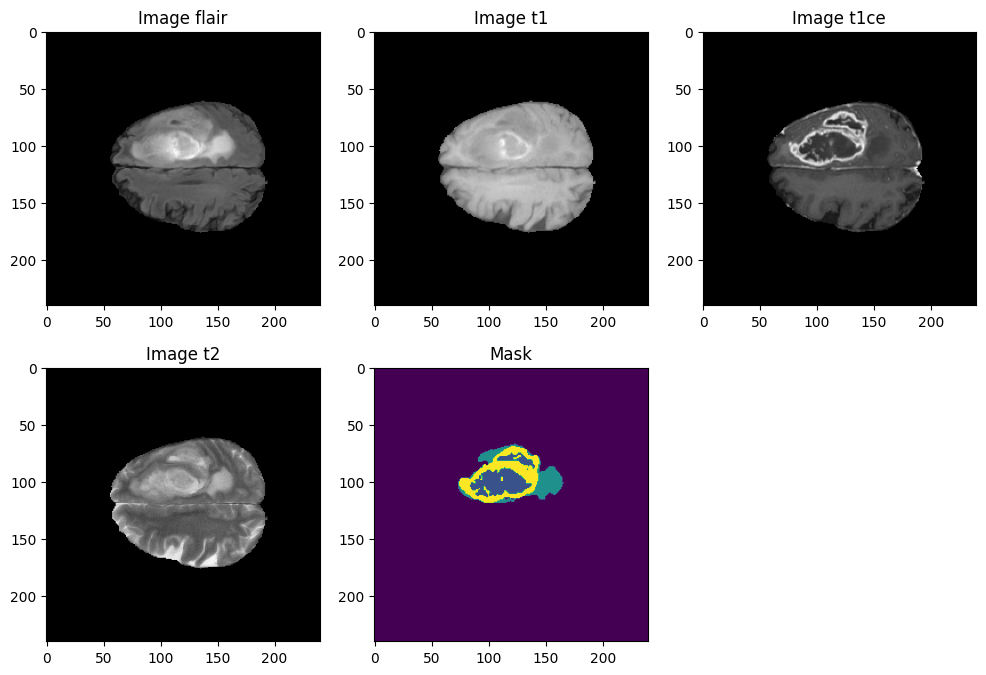

In [ ]:

import random
n_slice=random.randint(0, test_mask.shape[2])

plt.figure(figsize=(12, 8))

plt.subplot(231)
plt.imshow(test_image_flair[:,:,n_slice], cmap='gray')
plt.title('Image flair')
plt.subplot(232)
plt.imshow(test_image_t1[:,:,n_slice], cmap='gray')
plt.title('Image t1')
plt.subplot(233)
plt.imshow(test_image_t1ce[:,:,n_slice], cmap='gray')
plt.title('Image t1ce')
plt.subplot(234)
plt.imshow(test_image_t2[:,:,n_slice], cmap='gray')
plt.title('Image t2')
plt.subplot(235)
plt.imshow(test_mask[:,:,n_slice])
plt.title('Mask')
plt.show()


In [ ]:
#Flair, T1CE, annd T2 have the most information
#Combine t1ce, t2, and flair into single multichannel image
combined_x = np.stack([test_image_flair, test_image_t1ce,test_image_t2,test_image_t1], axis=3)
#cropping x, y, and z
combined_x=combined_x[56:184, 56:184, 13:141] #Crop to 128x128x128x4
#Do the same for mask
test_mask = test_mask[56:184, 56:184, 13:141]


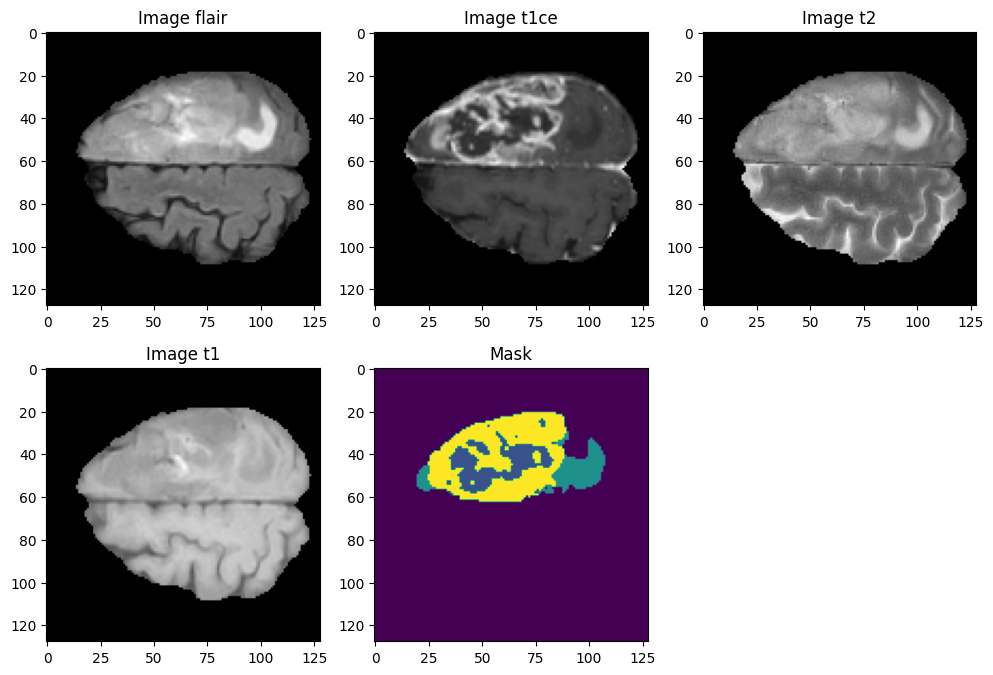

In [ ]:
n_slice=random.randint(0, test_mask.shape[2])
plt.figure(figsize=(12, 8))

plt.subplot(231)
plt.imshow(combined_x[:,:,n_slice, 0], cmap='gray')
plt.title('Image flair')
plt.subplot(232)
plt.imshow(combined_x[:,:,n_slice, 1], cmap='gray')
plt.title('Image t1ce')
plt.subplot(233)
plt.imshow(combined_x[:,:,n_slice, 2], cmap='gray')
plt.title('Image t2')
plt.subplot(234)
plt.imshow(combined_x[:,:,n_slice, 3], cmap='gray')
plt.title('Image t1')
plt.subplot(235)
plt.imshow(test_mask[:,:,n_slice])
plt.title('Mask')
plt.show()

In [ ]:
# # # images lists harley
#t1_list = sorted(glob.glob('/content/drive/MyDrive/Bratsdataset/BraTs2020_TrainingData/MICCAI_BraTS2020_TrainingData/*/*t1.nii'))
t2_list = sorted(glob.glob('/content/drive/MyDrive/Bratsdataset/BraTs2020_TrainingData/MICCAI_BraTS2020_TrainingData/*/*t2.nii'))
t1ce_list = sorted(glob.glob('/content/drive/MyDrive/Bratsdataset/BraTs2020_TrainingData/MICCAI_BraTS2020_TrainingData/*/*t1ce.nii'))
flair_list = sorted(glob.glob('/content/drive/MyDrive/Bratsdataset/BraTs2020_TrainingData/MICCAI_BraTS2020_TrainingData/*/*flair.nii'))
mask_list = sorted(glob.glob('/content/drive/MyDrive/Bratsdataset/BraTs2020_TrainingData/MICCAI_BraTS2020_TrainingData/*/*seg.nii'))

In [ ]:
for img in range(len(t2_list)):   #Using t2_list as all lists are of same size
  print("Now preparing image and masks number: ", img)

    #temp_image_t1=nib.load(t1_list[img]).get_fdata()
    #temp_image_t1=scaler.fit_transform(temp_image_t1.reshape(-1, temp_image_t1.shape[-1])).reshape(temp_image_t1.shape)

  temp_image_t2=nib.load(t2_list[img]).get_fdata()
  temp_image_t2=scaler.fit_transform(temp_image_t2.reshape(-1, temp_image_t2.shape[-1])).reshape(temp_image_t2.shape)

  temp_image_t1ce=nib.load(t1ce_list[img]).get_fdata()
  temp_image_t1ce=scaler.fit_transform(temp_image_t1ce.reshape(-1, temp_image_t1ce.shape[-1])).reshape(temp_image_t1ce.shape)

  temp_image_flair=nib.load(flair_list[img]).get_fdata()
  temp_image_flair=scaler.fit_transform(temp_image_flair.reshape(-1, temp_image_flair.shape[-1])).reshape(temp_image_flair.shape)

  temp_mask=nib.load(mask_list[img]).get_fdata()


  temp_mask[temp_mask==4] = 3  #Reassign mask values 4 to3


  temp_combined_images = np.stack([temp_image_flair, temp_image_t1ce, temp_image_t2], axis=3)
       #cropping x, y, and z
  temp_combined_images=temp_combined_images[56:184, 56:184, 13:141]
  temp_mask = temp_mask[56:184, 56:184, 13:141]

  val, counts = np.unique(temp_mask, return_counts=True)

  if (1 - (counts[0]/counts.sum())) > 0.01:  #At least 1% useful volume with labels that are not 0 because 0 is unlabel class which is=background
    print("Save Me")

    os.mkdir('/content/drive/MyDrive/Bratsdataset/BraTs2020/train'+str(img))
    np.save('/content/drive/MyDrive/Bratsdataset/BraTs2020/train'+str(img)+'/'+'image_'+str(img)+'.npy', temp_combined_images)
    np.save('/content/drive/MyDrive/Bratsdataset/BraTs2020/train'+str(img)+'/'+'mask_'+str(img)+'.npy', temp_mask)

  else:
      print("I am useless")

In [ ]:
import glob
import numpy as np
import tensorflow as tf
#from skimage.transform import resize
from keras.utils import to_categorical

dir_name='/content/drive/MyDrive/Bratsdataset/BraTs2020'
def load_img_mask(img_mask_list):

    images=[]

    masks=[]
    for i, image_name in enumerate(img_mask_list):

       try:
         image = np.load(glob.glob(dir_name+'/'+image_name +'/image_*.npy')[0])

         mask  =  np.load(glob.glob(dir_name+'/'+image_name+'/mask_*.npy')[0])

         mask=to_categorical(mask, num_classes=4)
         mask=mask.astype(np.float64)


         masks.append(mask)
         images.append(image)
       except Exception  as e:
         print('here is your error : ',e)
         print('my lists  : ', image_name, os.listdir(dir_name+'/'+image_name +'/') )
         print('shapes : ', mask.shape,image.shape)


    images = tf.convert_to_tensor(np.array(images))
    masks = tf.convert_to_tensor(np.array(masks))

    return(images,masks)

def imageLoader(images_names, batch_size):


    L = len(images_names)

    #keras needs the generator infinite, so we will use while true
    while True:

        batch_start = 0
        batch_end = batch_size

        while batch_start < L:
            limit = min(batch_end, L)

            X,Y = load_img_mask(images_names[batch_start:limit])

            yield (X,Y) #a tuple with two numpy arrays with batch_size samples

            batch_start += batch_size
            batch_end += batch_size


[0 1 2 3]


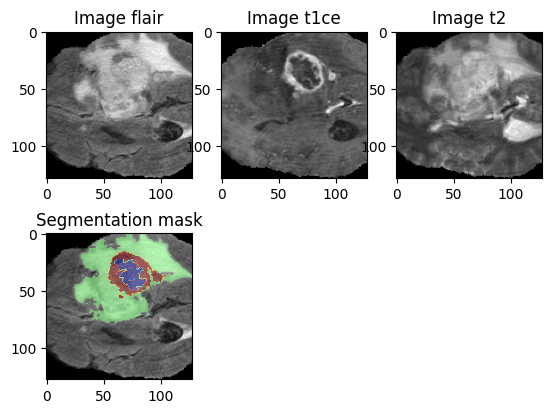

(1, 128, 128, 128, 4)
[0. 1.]
(1, 128, 128, 128, 3)


In [ ]:
# To Test Output of the Generator
train_path='/content/drive/MyDrive/Bratsdataset/BraTs2020'
val_path='/content/drive/MyDrive/Bratsdataset/BraTs2020'
train_img_list= os.listdir(train_path)
val_img_list= os.listdir(val_path)
batch_size=1
train_img_datagen1=imageLoader(train_img_list,batch_size)
val_img_datagen1=imageLoader(val_img_list,batch_size)

# #To verify generator
imgt, mskt = train_img_datagen1.__next__()
imgv, mskv = val_img_datagen1.__next__()
n_slice=58
test_mask=np.argmax(mskt, axis=4)
print(np.unique(test_mask))
plt.subplot(231)
plt.imshow(imgt[0,:,:,n_slice, 0], cmap='gray')
plt.title('Image flair')
plt.subplot(232)
plt.imshow(imgt[0,:,:,n_slice, 1], cmap='gray')
plt.title('Image t1ce')
plt.subplot(233)
plt.imshow(imgt[0,:,:,n_slice, 2], cmap='gray')
plt.title('Image t2')

# plot the mask on top of the image
masked_image = np.ma.masked_where(test_mask[0,:,:,n_slice] == 0, test_mask[0,:,:,n_slice])
plt.subplot(234)
plt.imshow(imgt[0,:,:,n_slice, 0], cmap='gray')
plt.imshow(masked_image, cmap='jet', alpha=0.5)
plt.title('Segmentation mask')

plt.show()

plt.show()



print(mskt.shape)
print(np.unique(mskt))

print(imgt.shape)


In [ ]:
import glob
import os

In [ ]:
import pickle
import keras
import keras.backend as K
import pandas as pd
from keras.callbacks import EarlyStopping, ReduceLROnPlateau
from sklearn.model_selection import KFold # import KFold
import time




kf = KFold(n_splits=5, random_state=1, shuffle=True)
#kfold = kf.split(train_img_list)
train_img_list=  os.listdir('/content/drive/MyDrive/Bratsdataset/BraTs2020/')
Kfolds=kf.split(train_img_list,train_img_list)
trainlist=[]
validationlist=[]
Histories=[]
nb_fold=0
train_5fold=[]
valid_5fold=[]
for train_idx, val_idx in Kfolds:

    print(' Training for the fold' +str(nb_fold)+' started ...')
    train_img_fold=[train_img_list[k] for k in list(train_idx)]
    valid_img_fold=[train_img_list[k] for k in list(val_idx)]
    list_valid = open('valid_list' + str(nb_fold) + '.pkl', "wb")
    pickle.dump(valid_img_fold, list_valid)
    list_valid.close()

    list_train = open('train_list' + str(nb_fold) + '.pkl', "wb")
    pickle.dump(train_img_fold, list_train)
    list_train.close()
    print(len(train_img_fold),len(valid_img_fold))
    train_5fold.append(train_img_fold)
    valid_5fold.append(valid_img_fold)
    nb_fold=nb_fold+1

five_fold_dic=dict(train=train_5fold,validation=valid_5fold)
list_train = open('folds_dic.pkl', "wb")
pickle.dump(five_fold_dic, list_train)
list_train.close()


 Training for the fold0 started ...
275 69
 Training for the fold1 started ...
275 69
 Training for the fold2 started ...
275 69
 Training for the fold3 started ...
275 69
 Training for the fold4 started ...
276 68


In [ ]:
'load histories'

with open('folds_dic.pkl', 'rb') as m:
      folds_dict = pickle.load(m)
valid_img_fold =  folds_dict['train'][0]
train_img_fold =  folds_dict['validation'][0]
valid_img_fold
train_img_fold


['train5',
 'train7',
 'train12',
 'train13',
 'train19',
 'train29',
 'train31',
 'train64',
 'train65',
 'train71',
 'train73',
 'train80',
 'train89',
 'train94',
 'train99',
 'train100',
 'train101',
 'train102',
 'train103',
 'train105',
 'train114',
 'train118',
 'train119',
 'train124',
 'train130',
 'train133',
 'train135',
 'train136',
 'train139',
 'train142',
 'train146',
 'train147',
 'train153',
 'train161',
 'train169',
 'train174',
 'train181',
 'train185',
 'train190',
 'train206',
 'train214',
 'train226',
 'train229',
 'train230',
 'train236',
 'train241',
 'train248',
 'train255',
 'train266',
 'train271',
 'train277',
 'train284',
 'train288',
 'train294',
 'train308',
 'train310',
 'train312',
 'train314',
 'train317',
 'train325',
 'train330',
 'train339',
 'train348',
 'train354',
 'train356',
 'train357',
 'train358',
 'train366',
 'train368']

In [ ]:
#Build the model
# Attention Model
import tensorflow as tf
from keras.models import Model
from keras.layers import Input, Reshape, Dense, Conv3D, BatchNormalization, UpSampling3D,Concatenate,Activation,Multiply, AveragePooling3D, MaxPooling3D, concatenate, GlobalAveragePooling3D, GlobalMaxPooling3D, Conv3DTranspose, BatchNormalization, Dropout, Lambda
from keras import regularizers
from tensorflow.keras.optimizers import Adam
from keras.metrics import MeanIoU
Lrelu = tf.keras.layers.LeakyReLU(alpha=0.1)
from tensorflow_addons.layers import InstanceNormalization
from tensorflow.python.keras.layers import Dropout, SpatialDropout3D

def SqueezeAndExcitation(inputs, ratio=8 ,name="attention"):
    b,_, _, _,c= inputs.shape
    x = GlobalAveragePooling3D()(inputs)
    x = Dense(c//ratio, activation="relu", use_bias=False)(x)
    x = Dense(c, activation="sigmoid", use_bias=False)(x)
    x = inputs * x
    return x

def CNN_Model(IMG_HEIGHT, IMG_WIDTH, IMG_DEPTH, IMG_CHANNELS, num_classes):
    kernel_initializer = 'he_uniform'
    inputs = Input((IMG_HEIGHT, IMG_WIDTH, IMG_DEPTH, IMG_CHANNELS), name='input_layer')
    s = inputs

    # Initial layers
    conv = Conv3D(32, (3, 3, 3), activation=Lrelu, kernel_initializer=kernel_initializer, padding='same', name='layer_1')(s)
    conv1 = Conv3D(32, (1, 1, 1), activation=Lrelu, kernel_initializer=kernel_initializer, padding='same', name='layer_2')(conv)
    pool1 = MaxPooling3D((2, 2, 2), name='layer_3_maxpool')(conv1)
    conv2 = Conv3D(32, (3, 3, 3), activation=Lrelu, kernel_initializer=kernel_initializer, padding='same', name='layer_4')(conv)
    pool2 = MaxPooling3D((2, 2, 2), name='layer_5_maxpool')(conv2)
    conv3 = Conv3D(32, (5, 5, 5), activation=Lrelu, kernel_initializer=kernel_initializer, padding='same', name='layer_6')(conv)
    pool3 = MaxPooling3D((2, 2, 2), name='layer_7_maxpool')(conv3)
    layer_out = concatenate([pool1, pool2, pool3], axis=-1, name='layer_8_concatenate')
    attention_layer1 = SqueezeAndExcitation(layer_out, name='attention_layer1')
    # Following layers
    conv4 = Conv3D(64, (3, 3, 3), activation=Lrelu, kernel_initializer=kernel_initializer, kernel_regularizer=regularizers.l2(0.02), padding='same', name='layer_9')(attention_layer1)
    B4 = InstanceNormalization(axis=-1, name='layer_10_instance_norm')(conv4)
    conv4 = Conv3D(64, (3, 3, 3), activation=Lrelu, kernel_initializer=kernel_initializer, kernel_regularizer=regularizers.l2(0.02), padding='same', name='layer_11')(B4)
    drop2 = Dropout(0.2, name='layer_12_dropout')(conv4)
    pool4 = MaxPooling3D((2, 2, 2), name='layer_13_maxpool')(drop2)

    # Following layers
    conv5 = Conv3D(128, (3, 3, 3), activation=Lrelu, kernel_initializer=kernel_initializer, kernel_regularizer=regularizers.l2(0.02), padding='same', name='layer_14_conv')(pool4)
    B5 = InstanceNormalization(axis=-1, name='layer_15_instance_norm')(conv5)
    conv5 = Conv3D(128, (3, 3, 3), activation=Lrelu, kernel_initializer=kernel_initializer, kernel_regularizer=regularizers.l2(0.02), padding='same', name='layer_16_conv')(B5)
    drop5 = Dropout(0.2, name='layer_17_dropout')(conv5)
    pool5 = MaxPooling3D((2, 2, 2), name='layer_18_maxpool')(drop5)
    attention_layer2 = SqueezeAndExcitation(pool5, name='attention_layer2')

    # Upsampling layers
    u9 = Conv3D(128, (2, 2, 2), activation=Lrelu, kernel_initializer=kernel_initializer, padding='same', name='upsample_layer_1_conv')(UpSampling3D(size=(2,2,2))(attention_layer2))
    u9 = InstanceNormalization(axis=-1, name='upsample_layer_1_instance_norm')(u9)
    u9 = concatenate([u9, conv5], name='upsample_layer_1_concatenate')
    c9 = Conv3D(128, (3, 3, 3), activation=Lrelu, kernel_initializer=kernel_initializer,
                kernel_regularizer=regularizers.l2(0.02), padding='same', name='upsample_layer_1_conv1')(u9)
    c9 = SqueezeAndExcitation(c9, name='attention_layer3')
    c9 = Dropout(0.2, name='upsample_layer_1_dropout')(c9)
    c9 = Conv3D(128, (3, 3, 3), activation=Lrelu, kernel_initializer=kernel_initializer,
               kernel_regularizer=regularizers.l2(0.02), padding='same', name='upsample_layer_1_conv2')(c9)


    u10= Conv3D(64, (2, 2, 2), activation=Lrelu, kernel_initializer=kernel_initializer, padding='same', name='upsample_layer_2_conv')(UpSampling3D(size =(2,2,2))(c9))
    u10 = InstanceNormalization(axis=-1, name='upsample_layer_2_instance_norm')(u10)
    u10 = concatenate([u10, conv4], name='upsample_layer_2_concatenate')
    c10= Conv3D(64, (3, 3, 3), activation=Lrelu, kernel_initializer=kernel_initializer,
              kernel_regularizer=regularizers.l2(0.02), padding='same', name='upsample_layer_2_conv1')(u10)
    c10 = SqueezeAndExcitation(c10, name='attention_layer4')
    c10 = Dropout(0.2, name='upsample_layer_2_dropout')(c10)
    c10= Conv3D(64, (3, 3, 3), activation=Lrelu, kernel_initializer=kernel_initializer,
                 kernel_regularizer=regularizers.l2(0.02), padding='same', name='upsample_layer_2_conv2')(c10)

    u11= Conv3D(32, (2, 2, 2), activation=Lrelu, kernel_initializer=kernel_initializer, padding='same', name='upsample_layer_3_conv')(UpSampling3D(size =(2,2,2))(c10))
    u11 = InstanceNormalization(axis=-1, name='upsample_layer_3_instance_norm')(u11)
    u11 = concatenate([u11,  conv], name='upsample_layer_3_concatenate')
    c11= Conv3D(32, (3, 3, 3), activation=Lrelu, kernel_initializer=kernel_initializer,
             kernel_regularizer=regularizers.l2(0.02), padding='same', name='upsample_layer_3_conv1')(u11)
    c11 = SqueezeAndExcitation(c11, name='attention_layer5')
    c11 = Dropout(0.2, name='upsample_layer_3_dropout')(c11)
    c11= Conv3D(32, (3, 3, 3), activation=Lrelu, kernel_initializer=kernel_initializer,
                 kernel_regularizer=regularizers.l2(0.02), padding='same', name='upsample_layer_3_conv2')(c11)

    outputs = Conv3D(num_classes, (1, 1, 1), kernel_regularizer=regularizers.l2(0.02), activation='softmax', name='final_output')(c11)

    model = Model(inputs=[inputs], outputs=[outputs])

    return model

#Test if everything is working ok.
model = CNN_Model(128, 128, 128, 3,4)


model.summary()
print(model.input_shape)
print(model.output_shape)

/usr/local/lib/python3.10/dist-packages/tensorflow_addons/utils/tfa_eol_msg.py:23: UserWarning: 

TensorFlow Addons (TFA) has ended development and introduction of new features.
TFA has entered a minimal maintenance and release mode until a planned end of life in May 2024.
Please modify downstream libraries to take dependencies from other repositories in our TensorFlow community (e.g. Keras, Keras-CV, and Keras-NLP). 

For more information see: https://github.com/tensorflow/addons/issues/2807 

  warnings.warn(


Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_layer (InputLayer)    [(None, 128, 128, 128, 3)]   0         []                            
                                                                                                  
 layer_1 (Conv3D)            (None, 128, 128, 128, 32)    2624      ['input_layer[0][0]']         
                                                                                                  
 layer_2 (Conv3D)            (None, 128, 128, 128, 32)    1056      ['layer_1[0][0]']             
                                                                                                  
 layer_4 (Conv3D)            (None, 128, 128, 128, 32)    27680     ['layer_1[0][0]']             
                                                                                              

In [ ]:
# No Attention Model
Lrelu = tf.keras.layers.LeakyReLU(alpha=0.1)
from tensorflow_addons.layers import InstanceNormalization
from tensorflow.python.keras.layers import Dropout, SpatialDropout3D


def CNN_ModelNo(IMG_HEIGHT, IMG_WIDTH, IMG_DEPTH, IMG_CHANNELS, num_classes):
    kernel_initializer = 'he_uniform'
    inputs = Input((IMG_HEIGHT, IMG_WIDTH, IMG_DEPTH, IMG_CHANNELS), name='input_layer')
    s = inputs

    # Initial layers
    conv = Conv3D(32, (3, 3, 3), activation=Lrelu, kernel_initializer=kernel_initializer, padding='same', name='layer_1')(s)
    conv1 = Conv3D(32, (1, 1, 1), activation=Lrelu, kernel_initializer=kernel_initializer, padding='same', name='layer_2')(conv)
    pool1 = MaxPooling3D((2, 2, 2), name='layer_3_maxpool')(conv1)
    conv2 = Conv3D(32, (3, 3, 3), activation=Lrelu, kernel_initializer=kernel_initializer, padding='same', name='layer_4')(conv)
    pool2 = MaxPooling3D((2, 2, 2), name='layer_5_maxpool')(conv2)
    conv3 = Conv3D(32, (5, 5, 5), activation=Lrelu, kernel_initializer=kernel_initializer, padding='same', name='layer_6')(conv)
    pool3 = MaxPooling3D((2, 2, 2), name='layer_7_maxpool')(conv3)
    layer_out = concatenate([pool1, pool2, pool3], axis=-1, name='layer_8_concatenate')

    conv4 = Conv3D(64, (3, 3, 3), activation=Lrelu, kernel_initializer=kernel_initializer, kernel_regularizer=regularizers.l2(0.02), padding='same', name='layer_9')(layer_out)
    B4 = InstanceNormalization(axis=-1, name='layer_10_instance_norm')(conv4)
    conv4 = Conv3D(64, (3, 3, 3), activation=Lrelu, kernel_initializer=kernel_initializer, kernel_regularizer=regularizers.l2(0.02), padding='same', name='layer_11')(B4)
    drop2 = Dropout(0.2, name='layer_12_dropout')(conv4)
    pool4 = MaxPooling3D((2, 2, 2), name='layer_13_maxpool')(drop2)

    # Following layers
    conv5 = Conv3D(128, (3, 3, 3), activation=Lrelu, kernel_initializer=kernel_initializer, kernel_regularizer=regularizers.l2(0.02), padding='same', name='layer_14_conv')(pool4)
    B5 = InstanceNormalization(axis=-1, name='layer_15_instance_norm')(conv5)
    conv5 = Conv3D(128, (3, 3, 3), activation=Lrelu, kernel_initializer=kernel_initializer, kernel_regularizer=regularizers.l2(0.02), padding='same', name='layer_16_conv')(B5)
    drop5 = Dropout(0.2, name='layer_17_dropout')(conv5)
    pool5 = MaxPooling3D((2, 2, 2), name='layer_18_maxpool')(drop5)

    # Upsampling layers
    u9 = Conv3D(128, (2, 2, 2), activation=Lrelu, kernel_initializer=kernel_initializer, padding='same', name='upsample_layer_1_conv')(UpSampling3D(size=(2,2,2))(pool5))
    u9 = InstanceNormalization(axis=-1, name='upsample_layer_1_instance_norm')(u9)
    u9 = concatenate([u9, conv5], name='upsample_layer_1_concatenate')
    c9 = Conv3D(128, (3, 3, 3), activation=Lrelu, kernel_initializer=kernel_initializer,
                kernel_regularizer=regularizers.l2(0.02), padding='same', name='upsample_layer_1_conv1')(u9)
    c9 = Dropout(0.2, name='upsample_layer_1_dropout')(c9)
    c9 = Conv3D(128, (3, 3, 3), activation=Lrelu, kernel_initializer=kernel_initializer,
               kernel_regularizer=regularizers.l2(0.02), padding='same', name='upsample_layer_1_conv2')(c9)


    u10= Conv3D(64, (2, 2, 2), activation=Lrelu, kernel_initializer=kernel_initializer, padding='same', name='upsample_layer_2_conv')(UpSampling3D(size =(2,2,2))(c9))
    u10 = InstanceNormalization(axis=-1, name='upsample_layer_2_instance_norm')(u10)
    u10 = concatenate([u10, conv4], name='upsample_layer_2_concatenate')
    c10= Conv3D(64, (3, 3, 3), activation=Lrelu, kernel_initializer=kernel_initializer,
              kernel_regularizer=regularizers.l2(0.02), padding='same', name='upsample_layer_2_conv1')(u10)
    c10 = Dropout(0.2, name='upsample_layer_2_dropout')(c10)
    c10= Conv3D(64, (3, 3, 3), activation=Lrelu, kernel_initializer=kernel_initializer,
                 kernel_regularizer=regularizers.l2(0.02), padding='same', name='upsample_layer_2_conv2')(c10)

    u11= Conv3D(32, (2, 2, 2), activation=Lrelu, kernel_initializer=kernel_initializer, padding='same', name='upsample_layer_3_conv')(UpSampling3D(size =(2,2,2))(c10))
    u11 = InstanceNormalization(axis=-1, name='upsample_layer_3_instance_norm')(u11)
    u11 = concatenate([u11,  conv], name='upsample_layer_3_concatenate')
    c11= Conv3D(32, (3, 3, 3), activation=Lrelu, kernel_initializer=kernel_initializer,
             kernel_regularizer=regularizers.l2(0.02), padding='same', name='upsample_layer_3_conv1')(u11)
    c11 = Dropout(0.2, name='upsample_layer_3_dropout')(c11)
    c11= Conv3D(32, (3, 3, 3), activation=Lrelu, kernel_initializer=kernel_initializer,
                 kernel_regularizer=regularizers.l2(0.02), padding='same', name='upsample_layer_3_conv2')(c11)

    outputs = Conv3D(num_classes, (1, 1, 1), kernel_regularizer=regularizers.l2(0.02), activation='softmax', name='final_output')(c11)

    model = Model(inputs=[inputs], outputs=[outputs])

    return model

#Test if everything is working ok.
modelno = CNN_ModelNo(128, 128, 128, 3,4)


modelno.summary()
print(modelno.input_shape)
print(modelno.output_shape)
layer_namesno = [layer.name for layer in model.layers]

print(layer_namesno)

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_layer (InputLayer)    [(None, 128, 128, 128, 3)]   0         []                            
                                                                                                  
 layer_1 (Conv3D)            (None, 128, 128, 128, 32)    2624      ['input_layer[0][0]']         
                                                                                                  
 layer_2 (Conv3D)            (None, 128, 128, 128, 32)    1056      ['layer_1[0][0]']             
                                                                                                  
 layer_4 (Conv3D)            (None, 128, 128, 128, 32)    27680     ['layer_1[0][0]']             
                                                                                            

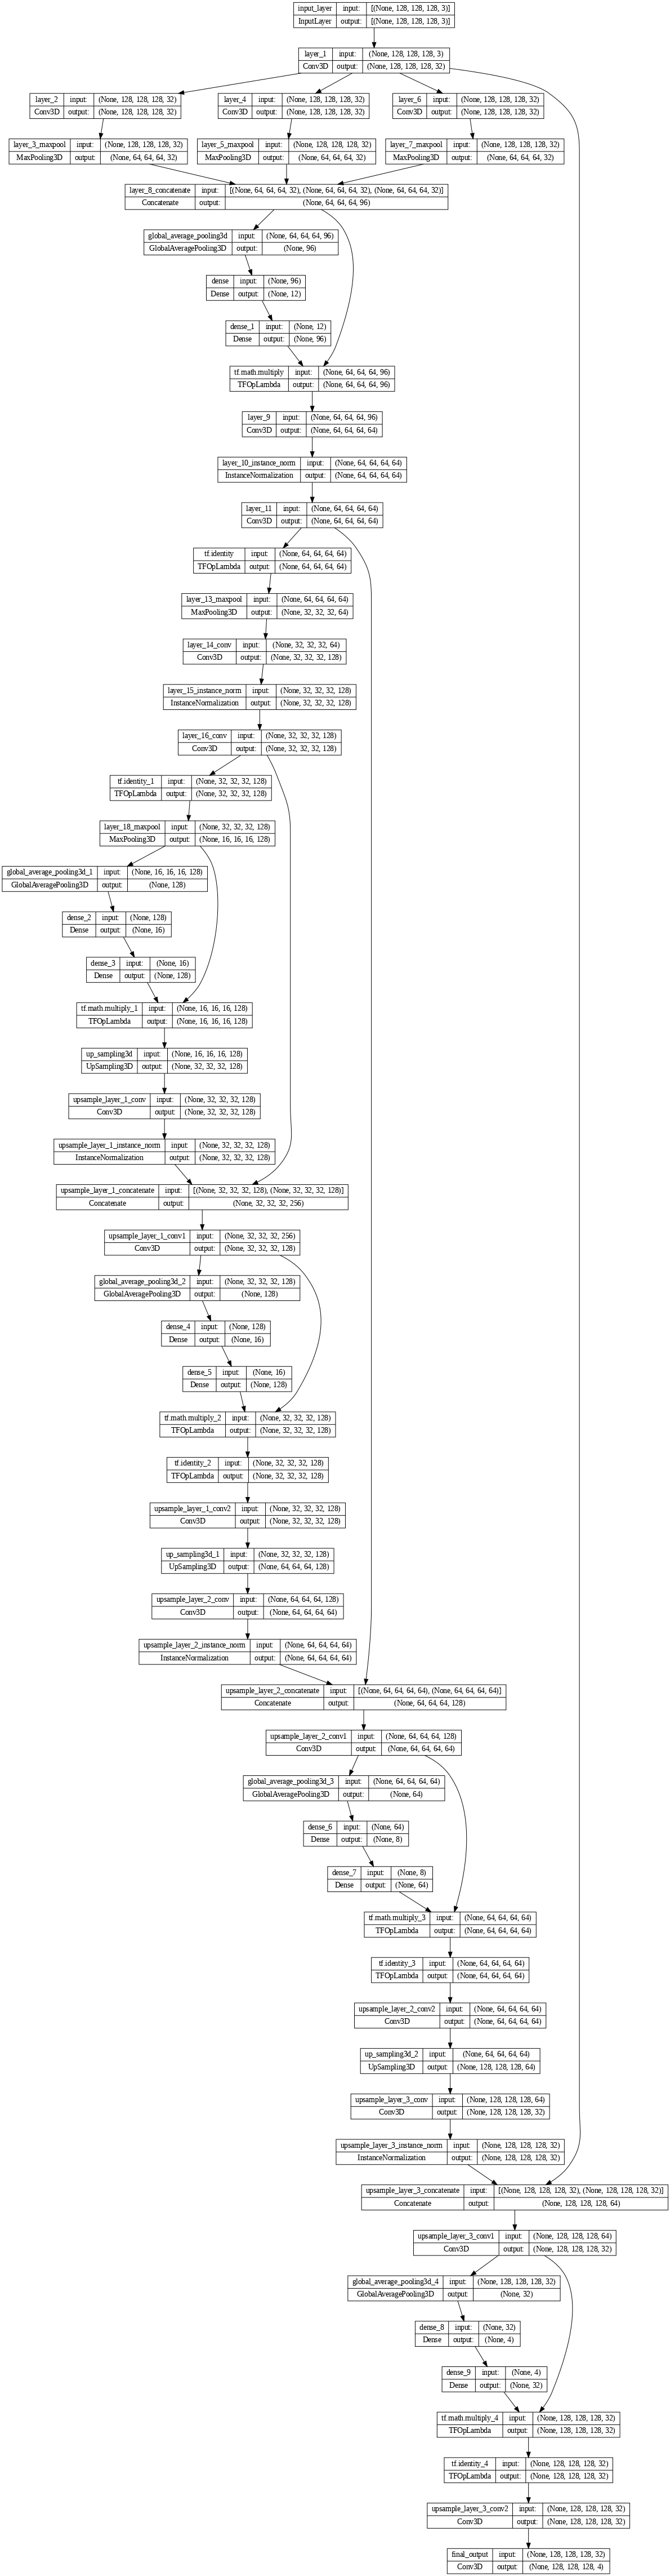

In [ ]:
from tensorflow.keras.utils import plot_model
plot_model(model,
           show_shapes = True,
           show_dtype = False,
           show_layer_names = True,
           rankdir = 'TB',
           expand_nested = False,
           dpi = 70)

In [ ]:
print ("computing class weights")
images_path="/content/drive/MyDrive/Bratsdataset/BraTs2020/"
val_list=os.listdir(images_path)
image_names=os.listdir(images_path)

for i, dir_name in enumerate(image_names[:]):
    print(' ********* ', i, dir_name)
def get_class_weights(images_path, class_names=['backg','1','2','3']):
    num_classes = len(class_names)
    trainId_to_count0 = [0 for k in range(num_classes)]
    trainId_to_count=trainId_to_count0
    for trainId in range(num_classes):
        trainId_to_count[trainId] = 0
    image_names_list=os.listdir(images_dir_path)
    for i, dir_name in enumerate( image_names_list):
        print(' ********* ', i, dir_name)
        label_img  = mask  = np.load(glob.glob(images_path+dir_name+'/'+'mask_*.npy')[0])
        ## change the aboenline to read the masks from the directory
        for trainId in range(num_classes):
            # count how many pixels in label_img which are of object class trainId:
            trainId_mask = np.equal(label_img, trainId)
            trainId_count = np.sum(trainId_mask)
          # print(trainId,trainId_count)
            # add to the total count:
            trainId_to_count0[trainId] += trainId_count
        if i % 10 == 0:
              print (i+1,' -patients so far',trainId_to_count0)
# compute the class weights according to the ENet paper:
    trainId_to_count[1]=trainId_to_count0[1]+trainId_to_count0[2]+trainId_to_count0[3]
    trainId_to_count[2]=trainId_to_count0[1]+trainId_to_count0[3]
    trainId_to_count[3]=trainId_to_count0[3]
    class_weights = []
    total_count = sum(trainId_to_count[1:])
    for trainId, count in enumerate(trainId_to_count[1:]):
        trainId_prob = float(count)/float(total_count)
        trainId_weight = 1/np.log(1.22 + trainId_prob)
        class_weights.append(trainId_weight)
    s=sum(class_weights)
    for idx, w in enumerate(class_weights):
        class_weights[idx]=class_weights[idx]/s
    data_info=dict(class_seg=['WT','CT','ET'],pixel_count=trainId_to_count[1:],class_weights=class_weights)
    return data_info
images_dir_path="/content/drive/MyDrive/Bratsdataset/BraTs2020/"
data_pixels_weights_info=get_class_weights(images_dir_path, class_names=['backg','1','2','3'])
print(data_pixels_weights_info)



computing class weights
 *********  0 train0
 *********  1 train1
 *********  2 train2
 *********  3 train3
 *********  4 train5
 *********  5 train6
 *********  6 train7
 *********  7 train8
 *********  8 train9
 *********  9 train10
 *********  10 train11
 *********  11 train12
 *********  12 train13
 *********  13 train14
 *********  14 train15
 *********  15 train16
 *********  16 train17
 *********  17 train18
 *********  18 train19
 *********  19 train20
 *********  20 train21
 *********  21 train22
 *********  22 train23
 *********  23 train24
 *********  24 train25
 *********  25 train26
 *********  26 train28
 *********  27 train29
 *********  28 train30
 *********  29 train31
 *********  30 train32
 *********  31 train33
 *********  32 train34
 *********  33 train36
 *********  34 train37
 *********  35 train38
 *********  36 train39
 *********  37 train40
 *********  38 train41
 *********  39 train42
 *********  40 train44
 *********  41 train45
 *********  42 train46
 *****

In [ ]:
#Define loss, metrics and optimizer to be used for training
import keras
import tensorflow as tf
import keras.backend as K
def dice_coef_class(y_true, y_pred,i, epsilon=0.00001):
    """
    Dice = (2*|X & Y|)/ (|X|+ |Y|)
         =  2*sum(|A*B|)/(sum(A^2)+sum(B^2))
    ref: https://arxiv.org/pdf/1606.04797v1.pdf

    """
    axis = (0,1,2,3)
    dice_numerator = 2. * K.sum(y_true[:,:,:,:,i:i+1] * y_pred[:,:,:,:,i:i+1], axis=axis) + epsilon
    dice_denominator = K.sum(y_true[:,:,:,:,i:i+1]*y_true[:,:,:,:,i:i+1], axis=axis) + K.sum(y_pred[:,:,:,:,i:i+1]*y_pred[:,:,:,:,i:i+1], axis=axis) + epsilon
    return K.mean((dice_numerator)/(dice_denominator))


def dice_coef_loss_3classes(y_true, y_pred):
    core=2-dice_coef_class(y_true, y_pred,1) -dice_coef_class(y_true, y_pred,3)
    whole=3-dice_coef_class(y_true, y_pred,1)-dice_coef_class(y_true, y_pred,2) -dice_coef_class(y_true, y_pred,3)
    enhance=1-dice_coef_class(y_true, y_pred,3)
    return 0.6*core + 0.5*whole +0.7*enhance





In [ ]:
#Define metrics and optimizer to be used for training
import tensorflow.keras
import tensorflow as tf
import tensorflow.keras.backend as K
#from segmentation_models_3D.losses import DiceLoss
from segmentation_models_3D.metrics import IOUScore, FScore
#dice_loss = DiceLoss()
FScores = FScore()
IOUScores = IOUScore(threshold=0.5)



LR=0.0001
metrics = ['accuracy',FScores,IOUScores]

optim = tf.keras.optimizers.Adam(LR)

In [ ]:
import pickle
import keras
import keras.backend as K
import pandas as pd
from keras.callbacks import EarlyStopping, ReduceLROnPlateau
from sklearn.model_selection import KFold # import KFold
import time

'load histories'
with open('folds_dic.pkl', 'rb') as m:
      folds_dict = pickle.load(m)



kf = KFold(n_splits=5, random_state=1, shuffle=True)
#kfold = kf.split(train_img_list)
train_img_list=  os.listdir('/content/drive/MyDrive/Bratsdataset/BraTs2020/')
Kfolds=kf.split(train_img_list,train_img_list)
trainlist=[]
validationlist=[]
Histories=[]
#nb_fold=0
batch_size=1
for nb_fold  in range(0,5):

    print(' Training for the fold' +str(nb_fold)+' started ...')

    train_img_fold =  folds_dict['train'][nb_fold]
    valid_img_fold =  folds_dict['validation'][nb_fold]
    steps_per_epoch = len( train_img_fold)//batch_size
    val_steps_per_epoch = len(valid_img_fold)//batch_size
    train_img_datagen1=imageLoader(train_img_fold,batch_size)
    val_img_datagen1=imageLoader(valid_img_fold,batch_size)
    LR=0.0001
    metrics = ['accuracy',FScores, IOUScores]

    optim = tf.keras.optimizers.Adam(LR)
    model =  CNN_Model(IMG_HEIGHT=128,
                          IMG_WIDTH=128,
                          IMG_DEPTH=128,
                          IMG_CHANNELS=3,
                          num_classes=4)

    print(model.summary())
    checkpoint_filepath = '/content/drive/MyDrive/2020/2020fold_'+str(nb_fold)+'-{epoch:03d}-{val_f1-score:.04f}.hdf5' # use your path

    model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_filepath,
                                                                monitor='val_f1-score', verbose=1,
                                                                save_best_only=True, mode='max')

    model.compile(optimizer = optim, loss=dice_coef_loss_3classes, metrics=metrics)



    start_time = time.time()
    model_history=model.fit(train_img_datagen1,
          steps_per_epoch=steps_per_epoch,
          epochs=200,
          verbose=1,
          validation_data=val_img_datagen1,
          validation_steps=val_steps_per_epoch,
          callbacks = [model_checkpoint_callback] )

    end_time = time.time()

    training_time = end_time - start_time
    # Print the training time of the model

    print("Training time: ", training_time, "seconds")
    model.save('last_model_fold'+str(nb_fold)+'.hdf5')
    history_df = pd.DataFrame(model_history.history)
    with open('fold_'+str(nb_fold)+'_history.csv', mode='w') as f:
                  history_df.to_csv(f)
            # 'Save the model'
    with open('model_history_fold_'+str(nb_fold)+'.pkl', 'wb') as f:
         pickle.dump(model_history.history, f)

    Histories.append(model_history.history)


'save all histories'
import pickle
with open('all_models_history.pkl', 'wb') as f:
      pickle.dump(Histories, f)


In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

# Load model data from CSV
def plot_cruves_for_onefold(nb_fold):
    # Load the CSV file into a pandas DataFrame
    df = pd.read_csv('2020/2020fold_' + str(nb_fold) + '.csv')

    loss = df['loss']
    val_loss = df['val_loss']
    epochs = range(1, len(loss) + 1)
    f, ax = plt.subplots(1, 3, figsize=(16, 8))

    ax[0].plot(epochs, loss, 'y', label='Training loss')
    ax[0].plot(epochs, val_loss, 'r', label='Validation loss')
    ax[0].legend()

    acc = df['accuracy']
    val_acc = df['val_accuracy']
    ax[1].plot(epochs, acc, 'y', label='Training acc')
    ax[1].plot(epochs, val_acc, 'r', label='Validation acc')
    ax[1].set_title('Training and validation acc')
    ax[1].set_xlabel('Epochs')
    ax[1].set_ylabel('acc')
    ax[1].legend()

    FScore = df['f1-score']
    val_FScore = df['val_f1-score']
    ax[2].plot(epochs, FScore, 'y', label='Training f_score')
    ax[2].plot(epochs, val_FScore, 'r', label='Validation f_score')
    ax[2].set_title('Training and validation FScore')
    ax[2].set_xlabel('Epochs')
    ax[2].set_ylabel('FScore')
    ax[2].legend()
    plt.show()

    iou_score = df['iou_score']
    val_iou_score = df['val_iou_score']

    plt.plot(epochs, iou_score, 'y', label='Training iou_score')
    plt.plot(epochs, val_iou_score, 'r', label='Validation iou_score')
    plt.title('Training and validation iou_score')
    plt.xlabel('Epochs')
    plt.ylabel('iou_score')
    plt.legend()
    plt.show()







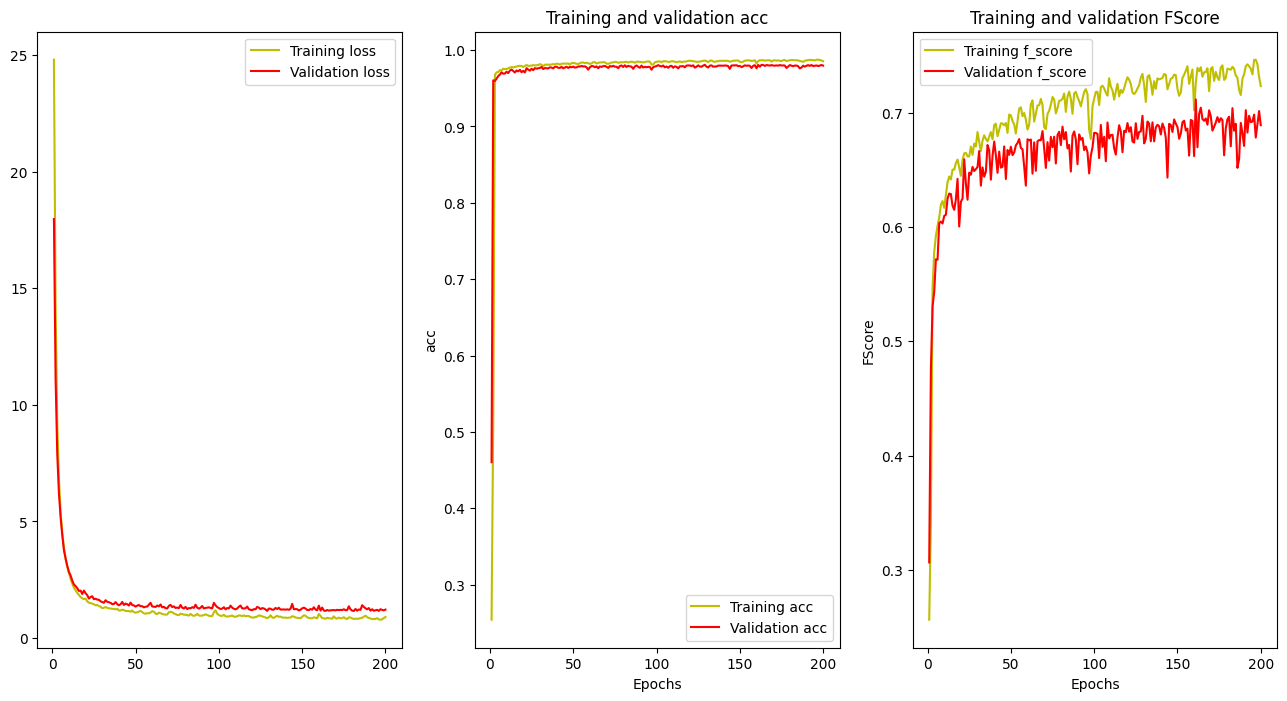

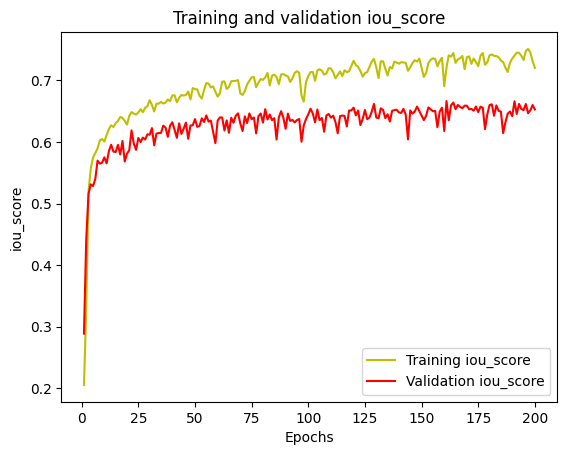

In [ ]:
plot_cruves_for_onefold(2)

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

# Load model data from CSV
def plot_cruves_for_onefold(nb_fold):
    # Load the CSV file into a pandas DataFrame
    df = pd.read_csv('2021/2021fold_' + str(nb_fold) + '.csv')

    loss = df['loss']
    val_loss = df['val_loss']
    epochs = range(1, len(loss) + 1)
    f, ax = plt.subplots(1, 3, figsize=(16, 8))

    ax[0].plot(epochs, loss, 'y', label='Training loss')
    ax[0].plot(epochs, val_loss, 'r', label='Validation loss')
    ax[0].legend()

    acc = df['accuracy']
    val_acc = df['val_accuracy']
    ax[1].plot(epochs, acc, 'y', label='Training acc')
    ax[1].plot(epochs, val_acc, 'r', label='Validation acc')
    ax[1].set_title('Training and validation acc')
    ax[1].set_xlabel('Epochs')
    ax[1].set_ylabel('acc')
    ax[1].legend()

    FScore = df['f1-score']
    val_FScore = df['val_f1-score']
    ax[2].plot(epochs, FScore, 'y', label='Training f_score')
    ax[2].plot(epochs, val_FScore, 'r', label='Validation f_score')
    ax[2].set_title('Training and validation FScore')
    ax[2].set_xlabel('Epochs')
    ax[2].set_ylabel('FScore')
    ax[2].legend()
    plt.show()

    iou_score = df['iou_score']
    val_iou_score = df['val_iou_score']

    plt.plot(epochs, iou_score, 'y', label='Training iou_score')
    plt.plot(epochs, val_iou_score, 'r', label='Validation iou_score')
    plt.title('Training and validation iou_score')
    plt.xlabel('Epochs')
    plt.ylabel('iou_score')
    plt.legend()
    plt.show()







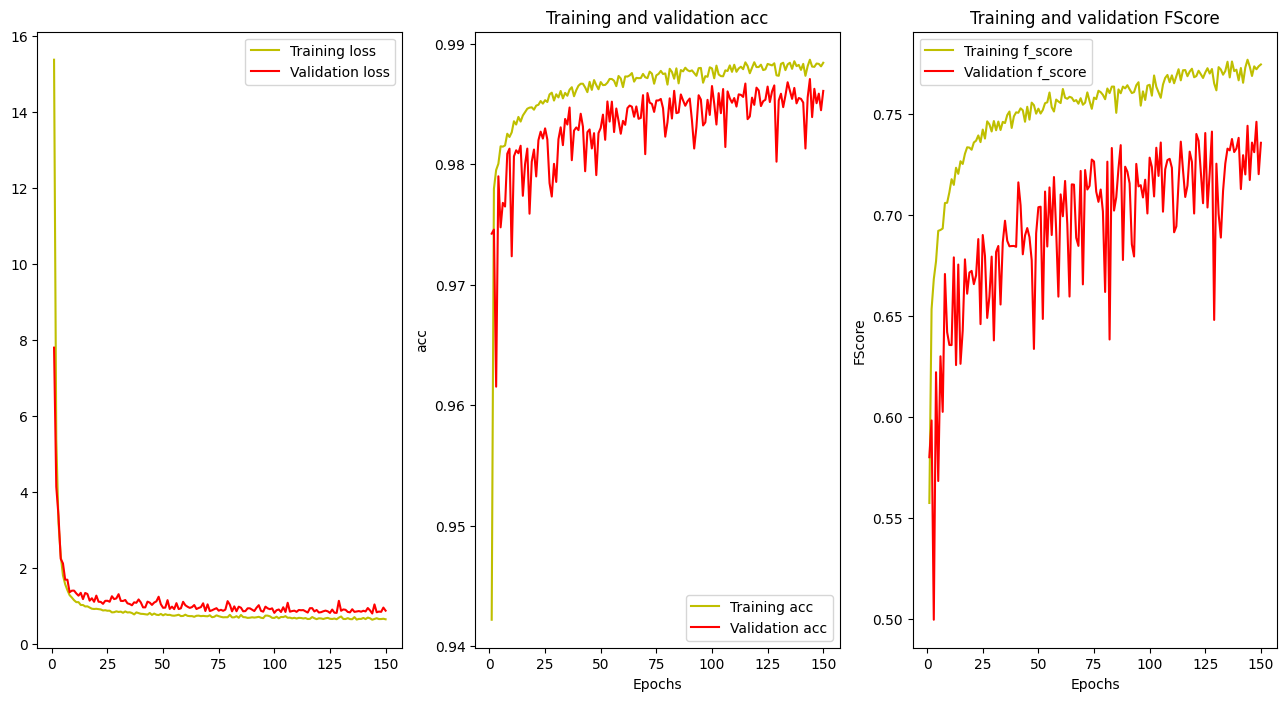

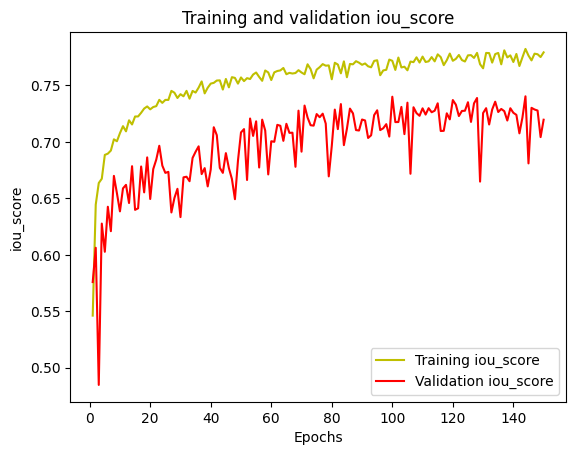

In [ ]:
plot_cruves_for_onefold(4)

In [ ]:
import numpy
from scipy.ndimage import _ni_support
from scipy.ndimage.morphology import distance_transform_edt, binary_erosion,\
    generate_binary_structure
from scipy.ndimage.measurements import label, find_objects
from scipy.stats import pearsonr

<ipython-input-12-de4130f88f9f>:3: DeprecationWarning: Please use `distance_transform_edt` from the `scipy.ndimage` namespace, the `scipy.ndimage.morphology` namespace is deprecated.
  from scipy.ndimage.morphology import distance_transform_edt, binary_erosion,\
<ipython-input-12-de4130f88f9f>:3: DeprecationWarning: Please use `binary_erosion` from the `scipy.ndimage` namespace, the `scipy.ndimage.morphology` namespace is deprecated.
  from scipy.ndimage.morphology import distance_transform_edt, binary_erosion,\
<ipython-input-12-de4130f88f9f>:3: DeprecationWarning: Please use `generate_binary_structure` from the `scipy.ndimage` namespace, the `scipy.ndimage.morphology` namespace is deprecated.
  from scipy.ndimage.morphology import distance_transform_edt, binary_erosion,\
<ipython-input-12-de4130f88f9f>:5: DeprecationWarning: Please use `label` from the `scipy.ndimage` namespace, the `scipy.ndimage.measurements` namespace is deprecated.
  from scipy.ndimage.measurements import label, 

In [ ]:
import difflib
import scipy.spatial
import numpy as np
import os
import glob
import SimpleITK as sitk
import medpy
import scipy.spatial
import medpy.metric.binary as medpyMetrics


def getHausdorff(testImage, resultImage):
    """Compute the Hausdorff distance."""

    # Hausdorff distance is only defined when something is detected
    resultStatistics = sitk.StatisticsImageFilter()
    resultStatistics.Execute(resultImage)
    if resultStatistics.GetSum() == 0:
        return float('nan')

    # Edge detection is done by ORIGINAL - ERODED, keeping the outer boundaries of lesions. Erosion is performed in 2D
    eTestImage   = sitk.BinaryErode(testImage, (1,1,0) )
    eResultImage = sitk.BinaryErode(resultImage, (1,1,0) )

    hTestImage   = sitk.Subtract(testImage, eTestImage)
    hResultImage = sitk.Subtract(resultImage, eResultImage)

    hTestArray   = sitk.GetArrayFromImage(hTestImage)
    hResultArray = sitk.GetArrayFromImage(hResultImage)

    # Convert voxel location to world coordinates. Use the coordinate system of the test image

    testCoordinates   = [testImage.TransformIndexToPhysicalPoint(x.tolist()) for x in np.transpose( np.flipud( np.nonzero(hTestArray) ))]
    resultCoordinates = [testImage.TransformIndexToPhysicalPoint(x.tolist()) for x in np.transpose( np.flipud( np.nonzero(hResultArray) ))]


    # Use a kd-tree for fast spatial search
    def getDistancesFromAtoB(a, b):
        kdTree = scipy.spatial.KDTree(a, leafsize=100)
        return kdTree.query(b, k=1, eps=0, p=2)[0]

    # Compute distances from test to result; and result to test
    dTestToResult = getDistancesFromAtoB(testCoordinates, resultCoordinates)
    dResultToTest = getDistancesFromAtoB(resultCoordinates, testCoordinates)

    return max(np.percentile(dTestToResult, 95), np.percentile(dResultToTest, 95))
def hd95(result, reference, voxelspacing=None, connectivity=1):
    try:
        hd1 = medpyMetrics.__surface_distances(result, reference, voxelspacing, connectivity)
        hd2 = medpyMetrics.__surface_distances(reference, result, voxelspacing, connectivity)
        hd95 = numpy.percentile(numpy.hstack((hd1, hd2)), 95)
    except:
        hd95 = 95
    return hd95
def getDSC(testImage, resultImage):
    """Compute the Dice Similarity Coefficient."""
    testArray   = sitk.GetArrayFromImage(testImage).flatten()
    resultArray = sitk.GetArrayFromImage(resultImage).flatten()

    # similarity = 1.0 - dissimilarity
    return 1.0 - scipy.spatial.distance.dice(testArray, resultArray)

def recall(result, reference):
    result = np.atleast_1d(result.astype(np.bool))
    reference = np.atleast_1d(reference.astype(np.bool))

    tp = np.count_nonzero(result & reference)
    fn = np.count_nonzero(~result & reference)

    try:
        recall = tp / float(tp + fn)
    except ZeroDivisionError:
        recall = 0.0

    return recall


def sensitivity(result, reference):

    return recall(result, reference)
def specificity(result, reference):

    result = np.atleast_1d(result.astype(np.bool))
    reference = np.atleast_1d(reference.astype(np.bool))

    tn = np.count_nonzero(~result & ~reference)
    fp = np.count_nonzero(result & ~reference)

    try:
        specificity = tn / float(tn + fp)
    except ZeroDivisionError:
        specificity = 0.0

    return specificity
Dice_all=[]
H95_all=[]



In [ ]:
import math
def get_score_per_sampe(my_model,image, maks):
           Disces=[list() for i in range(0,3)]
           Haus95s=[list() for i in range(0,3)]
           Specs=[list() for i in range(0,3)]
           Senss=[list() for i in range(0,3)]
           domains=['whole','Core','Enhance'] #[0,1,2]
           predcition=my_model.predict(image)
           prediction=np.argmax(predcition, axis=4)[0,:,:,:]

           for k, dom in enumerate(domains):
                if k==0:
                    test_prediction = (prediction>0.4).astype(int)
                    msk=(mask >0.4).astype(int)
                elif k==1:
                    test_prediction1=(prediction ==1).astype(int)
                    test_prediction2=(prediction ==3).astype(int)
                    test_prediction1=(test_prediction1 >0.4).astype(float)
                    test_prediction2=(test_prediction2 >0.4).astype(float)
                    test_prediction=test_prediction1 + test_prediction2
                    test_prediction=(test_prediction >0.4).astype(int)

                    msk1=(mask ==1).astype(int)
                    msk2=(mask ==3).astype(int)
                    msk1=(msk1 >0.4).astype(float)
                    msk2=(msk2 >0.4).astype(float)
                    msk=msk1+msk2
                    msk=(msk > 0.3).astype(int)
                   # print(np.unique(msk),np.unique(test_prediction))
                else:
                    test_prediction =(prediction ==3).astype(int)
                    test_prediction =(test_prediction >0.4).astype(int)
                    msk=(mask ==3).astype(int)

                Spec=specificity(test_prediction , msk)
                Sens=sensitivity(test_prediction , msk)
                image_sitk = sitk.GetImageFromArray(msk)
                image_sitk1 = sitk.GetImageFromArray(test_prediction)
                Dice=getDSC(image_sitk, image_sitk1)
                if math.isnan(Dice):
                    Dice=1
                print('dice ---- ',Dice)

                Haus=hd95(test_prediction , msk, voxelspacing=None, connectivity=1)
                Senss[k].append(100*Sens)
                Specs[k].append(100*Spec)
                Disces[k].append(100*Dice)
                Haus95s[k].append(Haus)
           return  Senss,Specs,Disces,Haus95s

In [ ]:
from keras.models import load_model
from tensorflow_addons.layers import InstanceNormalization
import pickle
images_path='/content/drive/MyDrive/Bratsdataset/BraTs2020/'
models_list=os.listdir('/content/drive/MyDrive/2020/')
Dices_all=[]
H95s_all=[]
Senss_all=[]
Specs_all=[]
open_file = open('/content/drive/MyDrive/folds_dic.pkl', "rb")
trainvallist = pickle.load(open_file)
open_file.close()
for k in range(0,5):

       fold=0
       model_for_this_fold=[m for m in models_list if '2020fold_'+str(k) in m]
       model = load_model('/content/drive/MyDrive/2020/'+model_for_this_fold[0],
                      compile=False)
# empty list to read list from a file
       val_list=trainvallist['validation'][k][:69]

 # open file and read the content in a list

# =============================================================================
       print(' ****** ',len(val_list))
       Dice_fold=[]
       H95_fold=[]
       Sens_fold=[]
       Spec_fold=[]
       for i, dir_name in enumerate(val_list):
           print(' ********* ', i, dir_name)
           image = np.load(glob.glob(images_path+dir_name+'/'+'image_*.npy')[0])
           image=np.expand_dims(image,0)
           mask = np.load(glob.glob(images_path+dir_name+'/'+'mask_*.npy')[0])
      #  mask=np.expand_dims(mask,3)
           print(mask.shape)
           print(np.unique(mask))
           Senss,Specs,Disces,Haus95s=get_score_per_sampe(model,image, mask)
           Dice_fold.append(Disces)
           H95_fold.append(Haus95s)
           Spec_fold.append(Specs)
           Sens_fold.append(Senss)

       Dices_all.append(Dice_fold)
       H95s_all.append(H95_fold)
       Specs_all.append(Spec_fold)
       Senss_all.append(Sens_fold)

import pickle
open_file = open('dscs2020_paper1.pkl', "wb")
pickle.dump(Dices_all, open_file)
open_file.close()
open_file = open('hds2020_paper1.pkl', "wb")
pickle.dump(H95s_all, open_file)
open_file.close()
open_file = open('specs2020_paper1.pkl', "wb")
pickle.dump(Specs_all, open_file)
open_file.close()
open_file = open('sensis2020_paper1.pkl', "wb")
pickle.dump(Senss_all, open_file)
open_file.close()

 ******  69
 *********  0 train10
(128, 128, 128)
[0. 1. 2. 3.]
1/1 [==============================] - 1s 695ms/step


<ipython-input-23-48be69b7e0e7>:83: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  result = np.atleast_1d(result.astype(np.bool))
<ipython-input-23-48be69b7e0e7>:84: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  reference = np.atleast_1d(reference.astype(np.bool))
<ipython-input-23-48be69b7e0e7>:64: DeprecationWarning: `np.bool` is a deprecated alia

dice ----  0.8857212816566391
dice ----  0.9203531330966318
dice ----  0.7668969253690912
 *********  1 train100
(128, 128, 128)
[0. 1. 2. 3.]
1/1 [==============================] - 0s 50ms/step
dice ----  0.9051978449648906
dice ----  0.8776826248452332
dice ----  0.8116623092960916
 *********  2 train104
(128, 128, 128)
[0. 1. 2. 3.]
1/1 [==============================] - 0s 48ms/step
dice ----  0.8818878432488465
dice ----  0.9493638676844783
dice ----  0.9032967032967033
 *********  3 train11
(128, 128, 128)
[0. 1. 2. 3.]
1/1 [==============================] - 0s 49ms/step
dice ----  0.8316564251468701
dice ----  0.9281927710843374
dice ----  0.848693700913608
 *********  4 train110
(128, 128, 128)
[0. 1. 2. 3.]
1/1 [==============================] - 0s 42ms/step
dice ----  0.8786012833343144
dice ----  0.934295588534255
dice ----  0.8573911532110889
 *********  5 train111
(128, 128, 128)
[0. 1. 2. 3.]
1/1 [==============================] - 0s 41ms/step
dice ----  0.936461477484069

 ******  69
 *********  0 train0
(128, 128, 128)
[0. 1. 2. 3.]
1/1 [==============================] - 1s 671ms/step
dice ----  0.8861974228998182
dice ----  0.9363777333303369
dice ----  0.8681893717073861
 *********  1 train6
(128, 128, 128)
[0. 1. 2. 3.]
1/1 [==============================] - 0s 36ms/step
dice ----  0.8540261050507598
dice ----  0.9148123631549467
dice ----  0.8548150322959484
 *********  2 train10
(128, 128, 128)
[0. 1. 2. 3.]
1/1 [==============================] - 0s 37ms/step
dice ----  0.8775684186718166
dice ----  0.9036183752148266
dice ----  0.7280377406604616
 *********  3 train15
(128, 128, 128)
[0. 1. 2. 3.]
1/1 [==============================] - 0s 39ms/step
dice ----  0.8694309297661732
dice ----  0.8226930465386935
dice ----  0.6404059689494046
 *********  4 train17
(128, 128, 128)
[0. 1. 2. 3.]
1/1 [==============================] - 0s 35ms/step
dice ----  0.7257074004975124
dice ----  0.5177901410272998
dice ----  0.5974968256847452
 *********  5 train

 ******  69
 *********  0 train9
(128, 128, 128)
[0. 1. 2. 3.]
1/1 [==============================] - 1s 671ms/step
dice ----  0.6876034096383019
dice ----  0.8938153064106185
dice ----  0.8727605397575665
 *********  1 train22
(128, 128, 128)
[0. 1. 2. 3.]
1/1 [==============================] - 0s 36ms/step
dice ----  0.859367106048776
dice ----  0.9506967373663887
dice ----  0.7996312939278719
 *********  2 train25
(128, 128, 128)
[0. 1. 2. 3.]
1/1 [==============================] - 0s 48ms/step
dice ----  0.8991620516686479
dice ----  0.778768222082723
dice ----  0.695413731921071
 *********  3 train30
(128, 128, 128)
[0. 1. 2. 3.]
1/1 [==============================] - 0s 37ms/step
dice ----  0.8740008083348303
dice ----  0.8900778051446001
dice ----  0.8470469883053192
 *********  4 train33
(128, 128, 128)
[0. 1. 2. 3.]
1/1 [==============================] - 0s 37ms/step
dice ----  0.9312021645459726
dice ----  0.9208760546537635
dice ----  0.7910513010587139
 *********  5 train34

 ******  69
 *********  0 train2
(128, 128, 128)
[0. 1. 2. 3.]
1/1 [==============================] - 1s 679ms/step
dice ----  0.7173069978489897
dice ----  0.8972472063232488
dice ----  0.8293261090416526
 *********  1 train11
(128, 128, 128)
[0. 1. 2. 3.]
1/1 [==============================] - 0s 37ms/step
dice ----  0.8127074126573834
dice ----  0.9086371023914558
dice ----  0.8235957772584415
 *********  2 train14
(128, 128, 128)
[0. 1. 2. 3.]
1/1 [==============================] - 0s 47ms/step
dice ----  0.9283071530572504
dice ----  0.7887702330579622
dice ----  0.838052338052338
 *********  3 train21
(128, 128, 128)
[0. 1. 2. 3.]
1/1 [==============================] - 0s 37ms/step
dice ----  0.9220189930321421
dice ----  0.9348529288527613
dice ----  0.8560952279732171
 *********  4 train24
(128, 128, 128)
[0. 1. 2. 3.]
1/1 [==============================] - 0s 36ms/step
dice ----  0.9140604605022712
dice ----  0.9562843681509771
dice ----  0.8649458698292122
 *********  5 train

 ******  68
 *********  0 train1
(128, 128, 128)
[0. 1. 2. 3.]
1/1 [==============================] - 1s 713ms/step
dice ----  0.9054425756414303
dice ----  0.9525828475231475
dice ----  0.843493298746217
 *********  1 train3
(128, 128, 128)
[0. 1. 2. 3.]
1/1 [==============================] - 0s 37ms/step
dice ----  0.9371916761535543
dice ----  0.9175483005560243
dice ----  0.8375881523272215
 *********  2 train8
(128, 128, 128)
[0. 1. 2. 3.]
1/1 [==============================] - 0s 37ms/step
dice ----  0.8353066614175811
dice ----  0.8141784633772831
dice ----  0.6997688614946957
 *********  3 train16
(128, 128, 128)
[0. 1. 2. 3.]
1/1 [==============================] - 0s 36ms/step
dice ----  0.9205745795095681
dice ----  0.8777157486754614
dice ----  0.7824614666043905
 *********  4 train23
(128, 128, 128)
[0. 1. 2. 3.]
1/1 [==============================] - 0s 38ms/step
dice ----  0.8550073822666315
dice ----  0.9152494842056768
dice ----  0.8854728647796418
 *********  5 train26

/usr/local/lib/python3.10/dist-packages/scipy/spatial/distance.py:1374: RuntimeWarning: invalid value encountered in divide
  return float((ntf + nft) / np.array(2.0 * ntt + ntf + nft))


(128, 128, 128)
[0. 1. 2. 3.]
1/1 [==============================] - 0s 37ms/step
dice ----  0.8745813978610781
dice ----  0.8539325842696629
dice ----  0.7516425755584757
 *********  51 train285
(128, 128, 128)
[0. 1. 2.]
1/1 [==============================] - 0s 40ms/step
dice ----  0.872595281306715
dice ----  0.3908962029196521
dice ----  0.0
 *********  52 train286
(128, 128, 128)
[0. 1. 2. 3.]
1/1 [==============================] - 0s 39ms/step
dice ----  0.9267007561220997
dice ----  0.7652710799357008
dice ----  0.667242555126165
 *********  53 train287
(128, 128, 128)
[0. 1. 2. 3.]
1/1 [==============================] - 0s 39ms/step
dice ----  0.9008017089058256
dice ----  0.6909942321969048
dice ----  0.8724124731309443
 *********  54 train297
(128, 128, 128)
[0. 1. 2. 3.]
1/1 [==============================] - 0s 39ms/step
dice ----  0.8652009939329726
dice ----  0.5888930301900857
dice ----  0.0
 *********  55 train300
(128, 128, 128)
[0. 1. 2. 3.]
1/1 [====================

In [ ]:
import pickle
from keras.models import load_model
from tensorflow_addons.layers import InstanceNormalization
images_path='/content/drive/MyDrive/Bratsdataset2021/BraTs2021/'
models_list=os.listdir('/content/drive/MyDrive/2021/')
Dices_all=[]
H95s_all=[]
Senss_all=[]
Specs_all=[]
open_file = open('/content/drive/MyDrive/folds_dic1.pkl', "rb")
trainvallist = pickle.load(open_file)
open_file.close()
for k in range(0,5):
       # the fold Number
       fold=0
       model_for_this_fold=[m for m in models_list if '2021fold_'+str(k) in m]
       model = load_model('/content/drive/MyDrive/2021/'+model_for_this_fold[0],
                      compile=False)
# empty list to read list from a file
       val_list=trainvallist['validation'][k][:230]

 # open file and read the content in a list

# =============================================================================
       print(' ****** ',len(val_list))
       Dice_fold=[]
       H95_fold=[]
       Sens_fold=[]
       Spec_fold=[]
       for i, dir_name in enumerate(val_list):
           print(' ********* ', i, dir_name)
           image = np.load(glob.glob(images_path+dir_name+'/'+'image_*.npy')[0])
           image=np.expand_dims(image,0)
           mask = np.load(glob.glob(images_path+dir_name+'/'+'mask_*.npy')[0])
           print(mask.shape)
           print(np.unique(mask))
           Senss,Specs,Disces,Haus95s=get_score_per_sampe(model,image, mask)
           Dice_fold.append(Disces)
           H95_fold.append(Haus95s)
           Spec_fold.append(Specs)
           Sens_fold.append(Senss)

       Dices_all.append(Dice_fold)
       H95s_all.append(H95_fold)
       Specs_all.append(Spec_fold)
       Senss_all.append(Sens_fold)

import pickle
open_file = open('dscs2021_paper1.pkl', "wb")
pickle.dump(Dices_all, open_file)
open_file.close()
open_file = open('hds2021_paper1.pkl', "wb")
pickle.dump(H95s_all, open_file)
open_file.close()
open_file = open('specs2021_paper1.pkl', "wb")
pickle.dump(Specs_all, open_file)
open_file.close()
open_file = open('sensis2021_paper1.pkl', "wb")
pickle.dump(Senss_all, open_file)
open_file.close()

 ******  230
 *********  0 train115
(128, 128, 128)
[0. 1. 2. 3.]
1/1 [==============================] - 7s 7s/step
dice ----  0.9116307455837976


<ipython-input-14-48be69b7e0e7>:83: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  result = np.atleast_1d(result.astype(np.bool))
<ipython-input-14-48be69b7e0e7>:84: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  reference = np.atleast_1d(reference.astype(np.bool))
<ipython-input-14-48be69b7e0e7>:64: DeprecationWarning: `np.bool` is a deprecated alia

dice ----  0.9565662380861
dice ----  0.9243845252051582
 *********  1 train1151
(128, 128, 128)
[0. 1. 2. 3.]
1/1 [==============================] - 0s 46ms/step
dice ----  0.9152323112060035
dice ----  0.9536888950698839
dice ----  0.8795124961431657
 *********  2 train1153
(128, 128, 128)
[0. 1. 2. 3.]
1/1 [==============================] - 0s 42ms/step
dice ----  0.9412043883138164
dice ----  0.9569449138222372
dice ----  0.9296288736537515
 *********  3 train1161
(128, 128, 128)
[0. 1. 2. 3.]
1/1 [==============================] - 0s 46ms/step
dice ----  0.930585368538505
dice ----  0.9745264863769878
dice ----  0.947581386794188
 *********  4 train1168
(128, 128, 128)
[0. 1. 2. 3.]
1/1 [==============================] - 0s 40ms/step
dice ----  0.911218710968912
dice ----  0.9378214118747078
dice ----  0.8791798662442802
 *********  5 train1176
(128, 128, 128)
[0. 1. 2. 3.]
1/1 [==============================] - 0s 42ms/step
dice ----  0.8240813279385064
dice ----  0.9551505804042

 ******  230
 *********  0 train1146
(128, 128, 128)
[0. 1. 2. 3.]
1/1 [==============================] - 0s 492ms/step
dice ----  0.9574453202765597
dice ----  0.9641969986245407
dice ----  0.9303442754203363
 *********  1 train1147
(128, 128, 128)
[0. 1. 2. 3.]
1/1 [==============================] - 0s 34ms/step
dice ----  0.9287539415026639
dice ----  0.9659834746217405
dice ----  0.9313665232534317
 *********  2 train1149
(128, 128, 128)
[0. 1. 2. 3.]
1/1 [==============================] - 0s 33ms/step
dice ----  0.9591037114015342
dice ----  0.9637788656480245
dice ----  0.9338144914746762
 *********  3 train1155
(128, 128, 128)
[0. 1. 2. 3.]
1/1 [==============================] - 0s 36ms/step
dice ----  0.9291174538053495
dice ----  0.961691752238946
dice ----  0.9308976933248445
 *********  4 train1154
(128, 128, 128)
[0. 1. 2. 3.]
1/1 [==============================] - 0s 33ms/step
dice ----  0.9557981090100112
dice ----  0.978668317667586
dice ----  0.9622246666487806
 *******

/usr/local/lib/python3.10/dist-packages/scipy/spatial/distance.py:1415: RuntimeWarning: invalid value encountered in divide
  return float((ntf + nft) / np.array(2.0 * ntt + ntf + nft))


dice ----  1
 *********  216 train1094
(128, 128, 128)
[0. 1. 2.]
1/1 [==============================] - 0s 34ms/step
dice ----  0.887228111204318
dice ----  0.8248955879203256
dice ----  0.0
 *********  217 train1096
(128, 128, 128)
[0. 1. 2. 3.]
1/1 [==============================] - 0s 33ms/step
dice ----  0.9275600289270779
dice ----  0.8768188417486691
dice ----  0.0012582573136206143
 *********  218 train1108
(128, 128, 128)
[0. 1. 2.]
1/1 [==============================] - 0s 34ms/step
dice ----  0.9288782533696369
dice ----  0.9031707747514559
dice ----  0.0
 *********  219 train1110
(128, 128, 128)
[0. 1. 2.]
1/1 [==============================] - 0s 34ms/step
dice ----  0.9319040326697294
dice ----  0.7929546971398805
dice ----  0.0
 *********  220 train1115
(128, 128, 128)
[0. 1. 3.]
1/1 [==============================] - 0s 34ms/step
dice ----  0.9083186653401699
dice ----  0.6357720150733837
dice ----  0.17738324971053643
 *********  221 train1116
(128, 128, 128)
[0. 1. 2.

 ******  230
 *********  0 train1144
(128, 128, 128)
[0. 2. 3.]
1/1 [==============================] - 1s 541ms/step
dice ----  0.7734340008957707
dice ----  0.8839200761179828
dice ----  0.8854368932038835
 *********  1 train1148
(128, 128, 128)
[0. 1. 2. 3.]
1/1 [==============================] - 0s 35ms/step
dice ----  0.9654411688190058
dice ----  0.9805074101984426
dice ----  0.9528516569478026
 *********  2 train1150
(128, 128, 128)
[0. 1. 2. 3.]
1/1 [==============================] - 0s 35ms/step
dice ----  0.8187865396123923
dice ----  0.7459646323627177
dice ----  0.5603587328214723
 *********  3 train1152
(128, 128, 128)
[0. 1. 2. 3.]
1/1 [==============================] - 0s 33ms/step
dice ----  0.9621406302936557
dice ----  0.7010597148154082
dice ----  0.9325932286555446
 *********  4 train1157
(128, 128, 128)
[0. 1. 2. 3.]
1/1 [==============================] - 0s 35ms/step
dice ----  0.9415498954865681
dice ----  0.9384798736153583
dice ----  0.9259322665431365
 ********

 ******  230
 *********  0 train1145
(128, 128, 128)
[0. 1. 2. 3.]
1/1 [==============================] - 0s 497ms/step
dice ----  0.8281085373116096
dice ----  0.9736366165831942
dice ----  0.9080115576569477
 *********  1 train1160
(128, 128, 128)
[0. 1. 2. 3.]
1/1 [==============================] - 0s 33ms/step
dice ----  0.9508207920318617
dice ----  0.9696338297581637
dice ----  0.915060522624552
 *********  2 train1179
(128, 128, 128)
[0. 1. 2. 3.]
1/1 [==============================] - 0s 35ms/step
dice ----  0.9506302670285788
dice ----  0.9825512253133956
dice ----  0.9604753444208196
 *********  3 train118
(128, 128, 128)
[0. 1. 2. 3.]
1/1 [==============================] - 0s 33ms/step
dice ----  0.9478896197288434
dice ----  0.5618213292766092
dice ----  0.802724126381601
 *********  4 train1183
(128, 128, 128)
[0. 1. 2. 3.]
1/1 [==============================] - 0s 33ms/step
dice ----  0.7885955719679958
dice ----  0.894669070306464
dice ----  0.8625624976145949
 *********

 ******  230
 *********  0 train1158
(128, 128, 128)
[0. 1. 2. 3.]
1/1 [==============================] - 0s 490ms/step
dice ----  0.8083218088320198
dice ----  0.8337001746638076
dice ----  0.6821125170795461
 *********  1 train1162
(128, 128, 128)
[0. 1. 2. 3.]
1/1 [==============================] - 0s 36ms/step
dice ----  0.6801414536321826
dice ----  0.9616847105193345
dice ----  0.9206982779701662
 *********  2 train1163
(128, 128, 128)
[0. 1. 2. 3.]
1/1 [==============================] - 0s 35ms/step
dice ----  0.9082721659694533
dice ----  0.8013964515540735
dice ----  0.7202985395959669
 *********  3 train1167
(128, 128, 128)
[0. 1. 2. 3.]
1/1 [==============================] - 0s 34ms/step
dice ----  0.9551573154034892
dice ----  0.9473864375449286
dice ----  0.9060228452751817
 *********  4 train117
(128, 128, 128)
[0. 1. 2. 3.]
1/1 [==============================] - 0s 34ms/step
dice ----  0.9239070565469372
dice ----  0.9491488648243486
dice ----  0.8822250295110485
 ******

In [ ]:
import numpy as np
import pickle
from os import listdir
from matplotlib import image
import matplotlib.pyplot as plt
import statistics
import pandas as pd
#model2
with open('dscs2020_paper1.pkl','rb') as f:
          dsc_scores = pickle.load(f)#[0]
with open('hds2020_paper1.pkl','rb') as f:
          hd95_scores = pickle.load(f)#[0]
with open('specs2020_paper1.pkl','rb') as f:
          spec_scores = pickle.load(f)#[0]
with open('sensis2020_paper1.pkl','rb') as f:
          sens_scores = pickle.load(f)#[0]

#Z=np.transpose(np.asarray(dsc_scores[4]))[0]

import copy
print(dsc_scores)
def plot_scores_per_region(k,metric='DSC'):
    domains=['Whole','Core','Enhance']
    'k=0 for whole, 1 for core and 1 for enhance'
    print(domains[k] , ' Tumor' )

    if metric=='DSC':
        print('plotting scores for the dice')
        dsc_scoresc=copy.deepcopy(dsc_scores)
        Z=np.transpose(np.asarray(dsc_scoresc[4]))[0]
        lst=[[np.mean(Z,axis=1)[0]],[np.mean(Z,axis=1)[1]],[np.mean(Z,axis=1)[2]]]
        dsc_scoresc[4].append(lst)
        score_mat=np.transpose(np.asarray(dsc_scoresc))[0][k]
    elif  metric=='HD95':
        print('plotting scores for the hd95')
        hd95_scoresc=copy.deepcopy(hd95_scores)
        Z=np.transpose(np.asarray(hd95_scoresc[4]))[0]
        lst=[[np.mean(Z,axis=1)[0]],[np.mean(Z,axis=1)[1]],[np.mean(Z,axis=1)[2]]]
        hd95_scoresc[4].append(lst)
        score_mat=np.transpose(np.asarray(hd95_scoresc))[0][k]
    elif   metric=='spec':
        print('plotting scores for the spec')
        spec_scoresc=copy.deepcopy(spec_scores)
        Z=np.transpose(np.asarray(spec_scoresc[4]))[0]
        lst=[[np.mean(Z,axis=1)[0]],[np.mean(Z,axis=1)[1]],[np.mean(Z,axis=1)[2]]]
        spec_scoresc[4].append(lst)
        score_mat=np.transpose(np.asarray(spec_scoresc))[0][k]
    elif   metric=='sens':
        print('plotting scores for the sens')
        sens_scoresc=copy.deepcopy(sens_scores)
        Z=np.transpose(np.asarray(sens_scoresc[4]))[0]
        lst=[[np.mean(Z,axis=1)[0]],[np.mean(Z,axis=1)[1]],[np.mean(Z,axis=1)[2]]]
        sens_scoresc[4].append(lst)
        score_mat=np.transpose(np.asarray(sens_scoresc))[0][k]
    print(score_mat)
    avg=np.mean(score_mat,axis=1)
    print('shape score mat',score_mat.shape[0])
    avg=avg.reshape(score_mat.shape[0],1)
    score_mat=np.append(score_mat,avg,axis=1)
    m1 = score_mat.mean(axis=0)
    st1 = score_mat.std(axis=0)
    fig, ax = plt.subplots(figsize=(10, 5))
    bp = ax.boxplot(score_mat, showmeans=True,vert=True,patch_artist=False)
    plt.xticks([1, 2, 3, 4, 5, 6], ['Fold 1', 'Fold 2', 'Fold 3','Fold 4','Fold 5','Avg'])
    plt.ylabel('DSC Score')
    for i, line in enumerate(bp['medians']):
        x, y = line.get_xydata()[1]
        text = ' μ={:.2f}\n σ={:.2f}'.format(m1[i], st1[i])
        ax.annotate(text, xy=(x, y))



[[[[88.57212816566391], [92.03531330966318], [76.68969253690912]], [[90.51978449648907], [87.76826248452332], [81.16623092960916]], [[88.18878432488465], [94.93638676844783], [90.32967032967034]], [[83.16564251468701], [92.81927710843374], [84.86937009136079]], [[87.86012833343145], [93.4295588534255], [85.7391153211089]], [[93.64614774840696], [97.34994493392071], [93.41551561958514]], [[88.70832989047108], [95.21169117992575], [91.29707595593747]], [[87.59522782808682], [91.72706465763876], [88.4576098059244]], [[92.33580921599315], [86.19840351345738], [88.72559990053462]], [[94.1652439113368], [93.36212976022567], [86.37039889380918]], [[92.54715378079864], [93.53546547778674], [76.89049720887967]], [[87.36663789614678], [80.42068946328705], [74.51211951226713]], [[91.46399414808131], [95.44381186517435], [87.57348891898731]], [[95.54468060763338], [93.65096790719801], [90.94678645473392]], [[94.89458307571044], [84.72926728636264], [61.1326479015675]], [[87.90558385210338], [93.15

In [ ]:
print(dsc_scores)
#score_mat = np.transpose(np.asarray(dsc_scores, dtype=object))[0]
#print(score_mat.shape)

[[[[88.57212816566391], [92.03531330966318], [76.68969253690912]], [[90.51978449648907], [87.76826248452332], [81.16623092960916]], [[88.18878432488465], [94.93638676844783], [90.32967032967034]], [[83.16564251468701], [92.81927710843374], [84.86937009136079]], [[87.86012833343145], [93.4295588534255], [85.7391153211089]], [[93.64614774840696], [97.34994493392071], [93.41551561958514]], [[88.70832989047108], [95.21169117992575], [91.29707595593747]], [[87.59522782808682], [91.72706465763876], [88.4576098059244]], [[92.33580921599315], [86.19840351345738], [88.72559990053462]], [[94.1652439113368], [93.36212976022567], [86.37039889380918]], [[92.54715378079864], [93.53546547778674], [76.89049720887967]], [[87.36663789614678], [80.42068946328705], [74.51211951226713]], [[91.46399414808131], [95.44381186517435], [87.57348891898731]], [[95.54468060763338], [93.65096790719801], [90.94678645473392]], [[94.89458307571044], [84.72926728636264], [61.1326479015675]], [[87.90558385210338], [93.15

Whole  Tumor
plotting scores for the dice
[[88.57212817 88.61974229 68.76034096 71.73069978 90.54425756]
 [90.5197845  85.40261051 85.9367106  81.27074127 93.71916762]
 [88.18878432 87.75684187 89.91620517 92.83071531 83.53066614]
 [83.16564251 86.94309298 87.40008083 92.2018993  92.05745795]
 [87.86012833 72.57074005 93.12021645 91.40604605 85.50073823]
 [93.64614775 86.85375939 84.98558237 92.88309146 81.22970069]
 [88.70832989 74.21456566 87.60081869 90.38839739 91.81542013]
 [87.59522783 90.11250384 86.7498111  91.70734515 94.27483411]
 [92.33580922 92.34913416 91.01701897 74.13220011 91.99470976]
 [94.16524391 77.76348966 89.45433604 82.09195994 52.53982567]
 [92.54715378 58.10315627 86.82294264 93.37008255 88.00711244]
 [87.3666379  88.072117   93.20139565 91.83230747 93.21818051]
 [91.46399415 91.13197011 67.96463875 91.15411546 92.94133016]
 [95.54468061 84.37348016 89.85309585 66.89238583 93.54148314]
 [94.89458308 74.03798987 90.83743103 86.5407726  74.97908909]
 [87.90558385

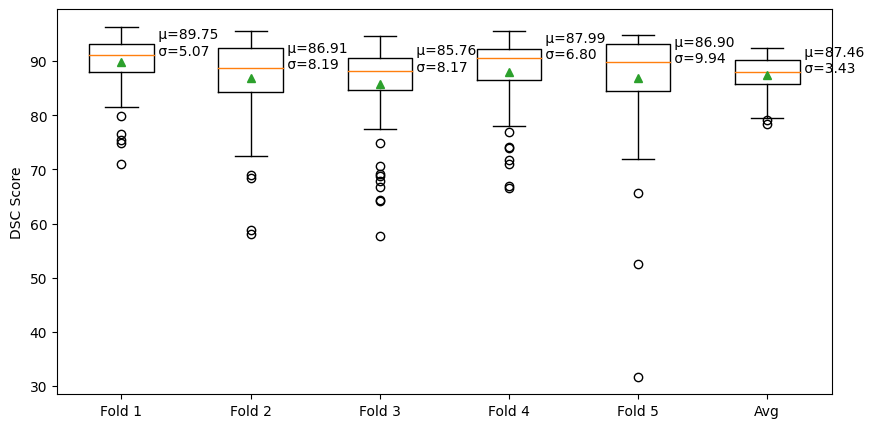

In [ ]:
'for example, if you want to plot the dices for the whoel tumor, you run'
plot_scores_per_region(0,metric='DSC')

[[[[88.57212816566391], [92.03531330966318], [76.68969253690912]], [[90.51978449648907], [87.76826248452332], [81.16623092960916]], [[88.18878432488465], [94.93638676844783], [90.32967032967034]], [[83.16564251468701], [92.81927710843374], [84.86937009136079]], [[87.86012833343145], [93.4295588534255], [85.7391153211089]], [[93.64614774840696], [97.34994493392071], [93.41551561958514]], [[88.70832989047108], [95.21169117992575], [91.29707595593747]], [[87.59522782808682], [91.72706465763876], [88.4576098059244]], [[92.33580921599315], [86.19840351345738], [88.72559990053462]], [[94.1652439113368], [93.36212976022567], [86.37039889380918]], [[92.54715378079864], [93.53546547778674], [76.89049720887967]], [[87.36663789614678], [80.42068946328705], [74.51211951226713]], [[91.46399414808131], [95.44381186517435], [87.57348891898731]], [[95.54468060763338], [93.65096790719801], [90.94678645473392]], [[94.89458307571044], [84.72926728636264], [61.1326479015675]], [[87.90558385210338], [93.15

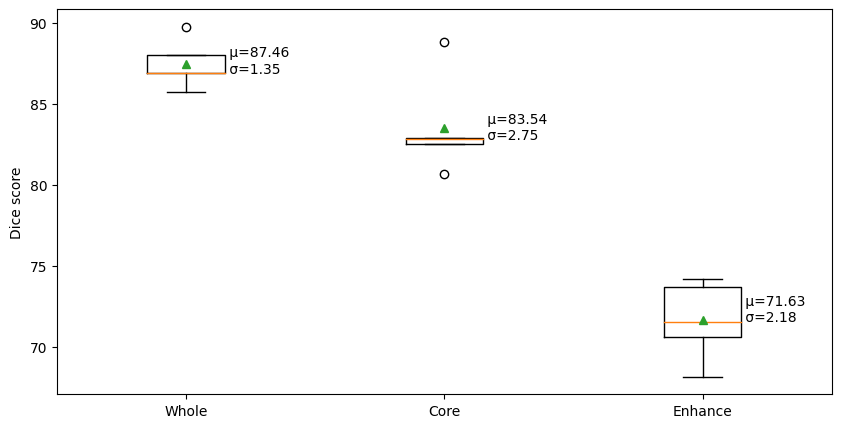

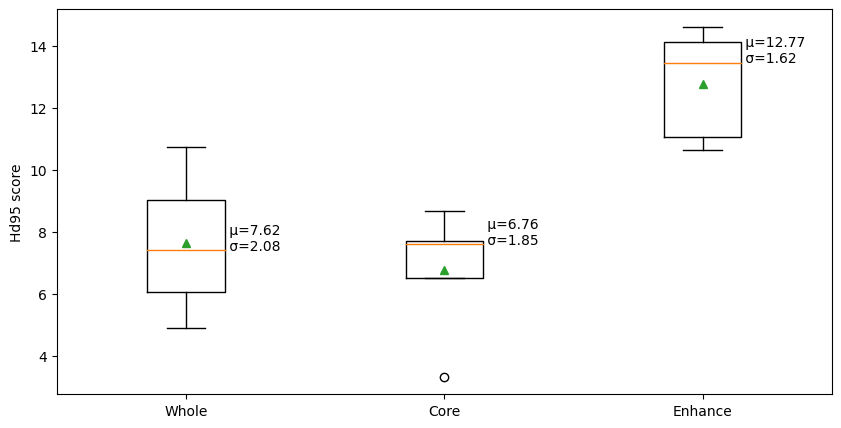

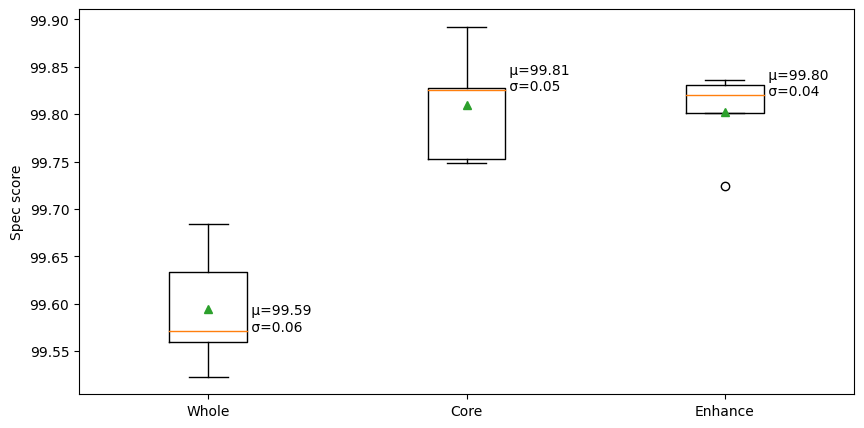

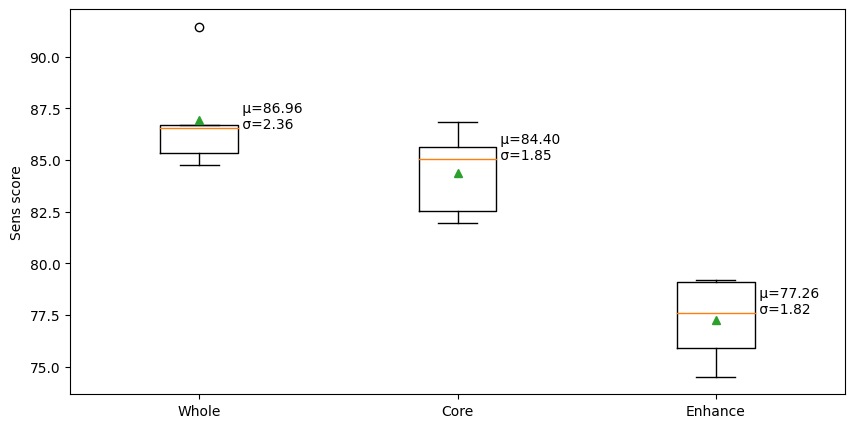

In [ ]:
import numpy as np
import pickle
from os import listdir
from matplotlib import image
import matplotlib.pyplot as plt
import statistics
import pandas as pd

# Load data
with open('dscs2020_paper1.pkl', 'rb') as f:
    dsc_scores = pickle.load(f)
with open('hds2020_paper1.pkl', 'rb') as f:
    hd95_scores = pickle.load(f)
with open('specs2020_paper1.pkl', 'rb') as f:
    spec_scores = pickle.load(f)
with open('sensis2020_paper1.pkl', 'rb') as f:
    sens_scores = pickle.load(f)

print(dsc_scores)


def calculate_average(metric_scores):
    avg_scores = []
    for scores in metric_scores:
        Z = np.transpose(np.asarray(scores))[0]
        avg_region = [np.mean(Z, axis=1)[i] for i in range(3)]
        avg_scores.append(avg_region)
    return np.asarray(avg_scores)


def plot_average_scores(averages, metric='DSC'):
    domains = ['Whole', 'Core', 'Enhance']
    fig, ax = plt.subplots(figsize=(10, 5))
    bp = ax.boxplot(averages, showmeans=True, vert=True, patch_artist=False)
    plt.xticks([1, 2, 3], domains)
    plt.ylabel(f'{metric.capitalize()} score')

    m1 = averages.mean(axis=0)
    st1 = averages.std(axis=0)
    for i, line in enumerate(bp['medians']):
        x, y = line.get_xydata()[1]
        text = ' μ={:.2f}\n σ={:.2f}'.format(m1[i], st1[i])
        ax.annotate(text, xy=(x, y))
    plt.show()


dsc_avg = calculate_average(dsc_scores)
hd95_avg = calculate_average(hd95_scores)
spec_avg = calculate_average(spec_scores)
sens_avg = calculate_average(sens_scores)

plot_average_scores(dsc_avg, metric='dice')
plot_average_scores(hd95_avg, metric='hd95')
plot_average_scores(spec_avg, metric='spec')
plot_average_scores(sens_avg, metric='sens')

Whole Tumor DSC
plotting scores for the dice
[[88.57212817 88.61974229 68.76034096 71.73069978 90.54425756]
 [90.5197845  85.40261051 85.9367106  81.27074127 93.71916762]
 [88.18878432 87.75684187 89.91620517 92.83071531 83.53066614]
 [83.16564251 86.94309298 87.40008083 92.2018993  92.05745795]
 [87.86012833 72.57074005 93.12021645 91.40604605 85.50073823]
 [93.64614775 86.85375939 84.98558237 92.88309146 81.22970069]
 [88.70832989 74.21456566 87.60081869 90.38839739 91.81542013]
 [87.59522783 90.11250384 86.7498111  91.70734515 94.27483411]
 [92.33580922 92.34913416 91.01701897 74.13220011 91.99470976]
 [94.16524391 77.76348966 89.45433604 82.09195994 52.53982567]
 [92.54715378 58.10315627 86.82294264 93.37008255 88.00711244]
 [87.3666379  88.072117   93.20139565 91.83230747 93.21818051]
 [91.46399415 91.13197011 67.96463875 91.15411546 92.94133016]
 [95.54468061 84.37348016 89.85309585 66.89238583 93.54148314]
 [94.89458308 74.03798987 90.83743103 86.5407726  74.97908909]
 [87.90558

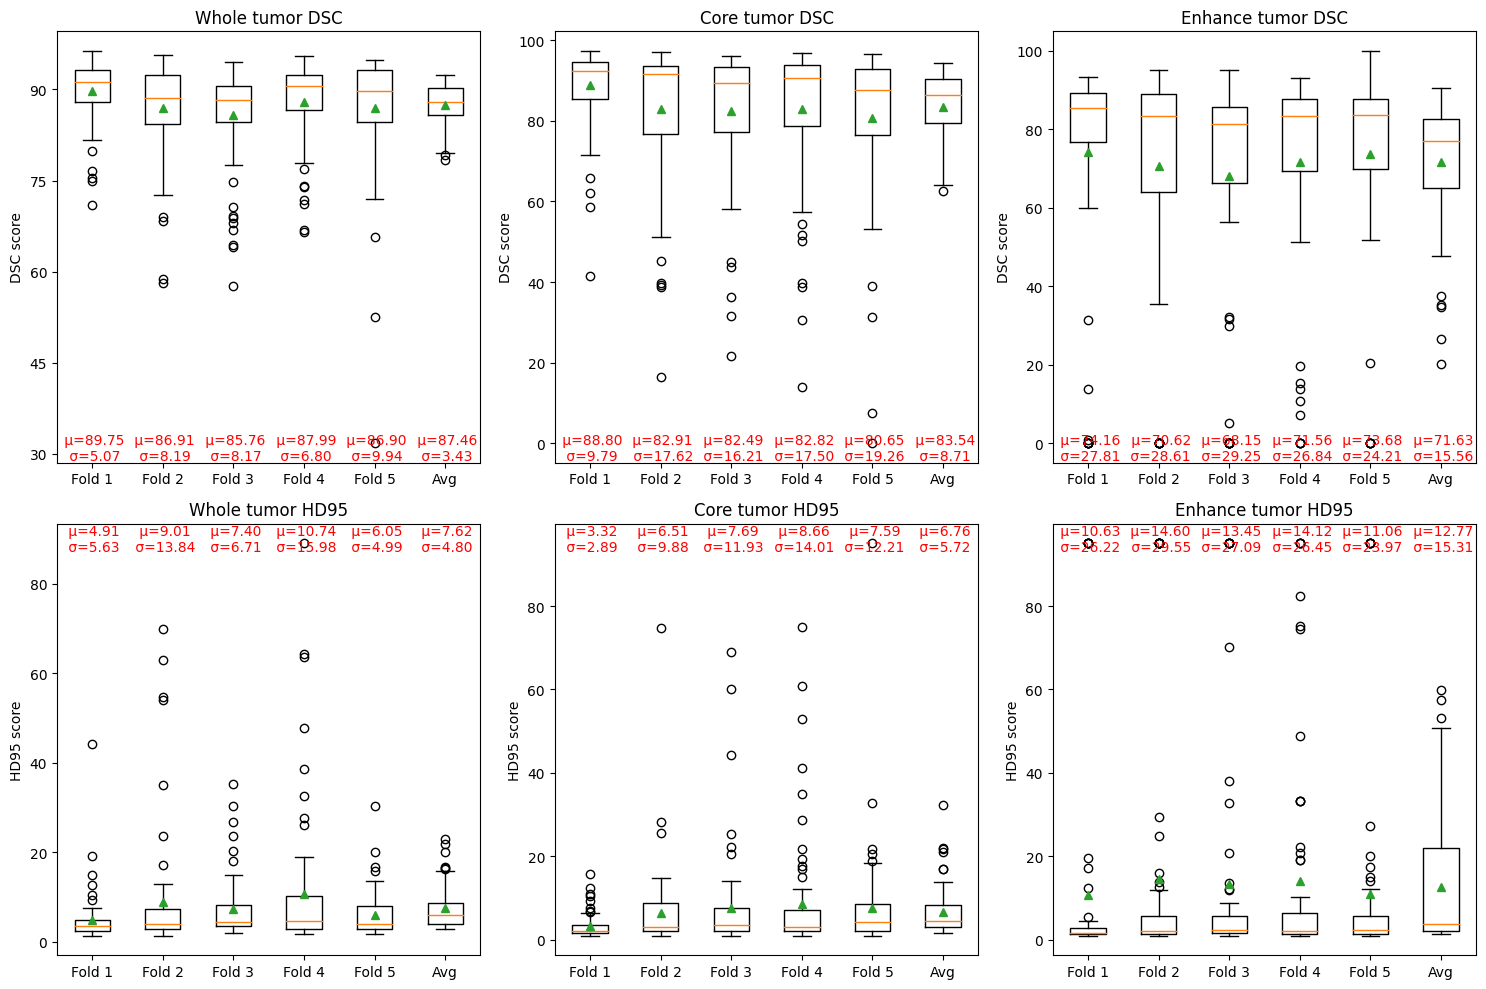

In [ ]:
import numpy as np
import pickle
from matplotlib import pyplot as plt
from matplotlib.ticker import MaxNLocator

def plot_scores_per_region(metrics=['DSC', 'HD95']):
    with open('dscs2020_paper1.pkl', 'rb') as f:
        dsc_scores = pickle.load(f)
    with open('hds2020_paper1.pkl', 'rb') as f:
        hd95_scores = pickle.load(f)
    with open('specs2020_paper1.pkl', 'rb') as f:
        spec_scores = pickle.load(f)
    with open('sensis2020_paper1.pkl', 'rb') as f:
        sens_scores = pickle.load(f)

    domains = ['Whole', 'Core', 'Enhance']
    fig, axs = plt.subplots(2, 3, figsize=(15, 10))

    for k in range(3):
        for j, metric in enumerate(metrics):
            print(domains[k], 'Tumor', metric)
            if metric == 'DSC':
                print('plotting scores for the dice')
                scores = copy.deepcopy(dsc_scores)
                text_va = 'bottom'  # Align text at the bottom for 'dice'
            elif metric == 'HD95':
                print('plotting scores for the hd95')
                scores = copy.deepcopy(hd95_scores)
                text_va = 'top'  # Align text at the top for 'hd95'
            elif metric == 'spec':
                print('plotting scores for the spec')
                scores = copy.deepcopy(spec_scores)
                text_va = 'bottom'  # Align text at the bottom for 'spec'
            elif metric == 'sens':
                print('plotting scores for the sens')
                scores = copy.deepcopy(sens_scores)
                text_va = 'bottom'  # Align text at the bottom for 'sens'

            Z = np.transpose(np.asarray(scores[4]))[0]
            lst = [[np.mean(Z, axis=1)[0]], [np.mean(Z, axis=1)[1]], [np.mean(Z, axis=1)[2]]]
            scores[4].append(lst)
            score_mat = np.transpose(np.asarray(scores))[0][k]

            print(score_mat)
            avg = np.mean(score_mat, axis=1)
            print('shape score mat', score_mat.shape[0])
            avg = avg.reshape(score_mat.shape[0], 1)
            score_mat = np.append(score_mat, avg, axis=1)
            m1 = score_mat.mean(axis=0)
            st1 = score_mat.std(axis=0)

            ax = axs[j, k]
            bp = ax.boxplot(score_mat, showmeans=True, vert=True, patch_artist=False)
            ax.set_title(domains[k] + ' tumor' + ' ' + metric)
            ax.set_xticklabels(['Fold 1', 'Fold 2', 'Fold 3', 'Fold 4', 'Fold 5', 'Avg'])
            ax.yaxis.set_major_locator(MaxNLocator(nbins=6))
            ax.set_ylabel(metric + ' score')
            for i in range(len(m1)):
                text_y = ax.get_ylim()[0] if text_va == 'bottom' else ax.get_ylim()[1]
                ax.text(i+1, text_y, ' μ={:.2f}\n σ={:.2f}'.format(m1[i], st1[i]), ha='center', va=text_va, color='red', fontsize=10)

    plt.tight_layout()
    plt.show()

plot_scores_per_region(metrics=['DSC', 'HD95'])

[[[[91.16307455837976], [95.65662380861], [92.43845252051582]], [[91.52323112060034], [95.36888950698838], [87.95124961431657]], [[94.12043883138163], [95.69449138222372], [92.96288736537515]], [[93.0585368538505], [97.45264863769879], [94.7581386794188]], [[91.1218710968912], [93.78214118747078], [87.91798662442802]], [[82.40813279385064], [95.51505804042536], [87.81772475160608]], [[95.69845848336884], [98.16374663072777], [95.5825765738033]], [[92.51769744067782], [97.65584302830352], [87.89411937234199]], [[78.00248976663713], [92.22661396574439], [87.95013850415513]], [[81.28883930654473], [87.79390717644652], [84.9573023866871]], [[90.72815040252861], [93.80118975773773], [93.55072673996925]], [[95.27718103953352], [96.91276594716572], [89.2296294633336]], [[75.73804029783287], [0.0], [0.0]], [[96.06969448718205], [98.08946356991903], [92.69251101321586]], [[95.69907497973898], [90.41095890410959], [80.35346862749346]], [[65.63897006318594], [53.63262691506967], [38.6276819820784

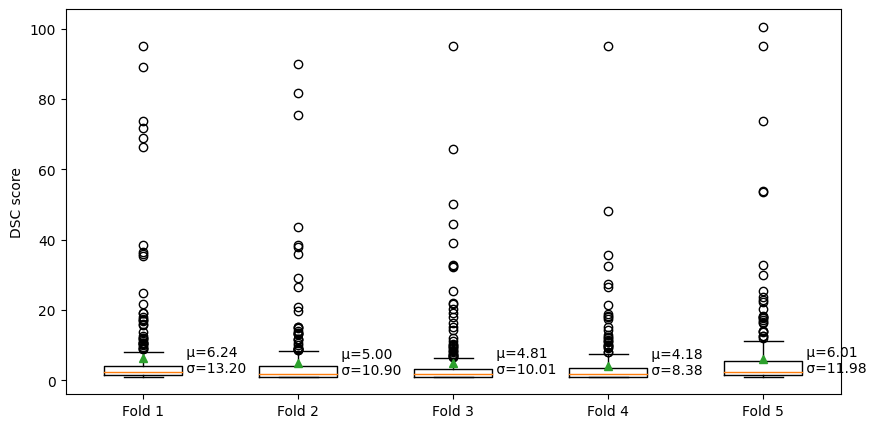

In [ ]:
import numpy as np
import pickle
from os import listdir
from matplotlib import image
import matplotlib.pyplot as plt
import statistics
import pandas as pd
#model2
with open('dscs2021_paper1.pkl','rb') as f:
          dsc_scores = pickle.load(f)#[0]
with open('hds2021_paper1.pkl','rb') as f:
          hd95_scores = pickle.load(f)#[0]
with open('specs2021_paper1.pkl','rb') as f:
          spec_scores = pickle.load(f)#[0]
with open('sensis2021_paper1.pkl','rb') as f:
          sens_scores = pickle.load(f)#[0]


import copy
print(dsc_scores)
def plot_scores_per_region(k,metric='DSC'):
    domains=['Whole','Core','Enhance']
    'k=0 for whole, 1 for core and 1 for enhance'
    print(domains[k] , ' tumor' )

    if metric=='DSC':
        print('plotting scores for the dice')
        dsc_scoresc=copy.deepcopy(dsc_scores)
        Z=np.transpose(np.asarray(dsc_scoresc))[0][k]

    elif  metric=='HD95':
        print('plotting scores for the hd95')
        hd95_scoresc=copy.deepcopy(hd95_scores)
        Z=np.transpose(np.asarray(hd95_scoresc))[0][k]

    elif   metric=='spec':
        print('plotting scores for the spec')
        spec_scoresc=copy.deepcopy(spec_scores)
        Z=np.transpose(np.asarray(spec_scoresc))[0][k]

    elif   metric=='sens':
        print('plotting scores for the sens')
        sens_scoresc=copy.deepcopy(sens_scores)
        Z=np.transpose(np.asarray(sens_scoresc))[0][k]

    score_mat=Z
    avg=np.mean(score_mat,axis=1)
    print('shape score mat',score_mat.shape[0])
    avg=avg.reshape(score_mat.shape[0],1)

    m1 = score_mat.mean(axis=0)
    st1 = score_mat.std(axis=0)
    fig, ax = plt.subplots(figsize=(10, 5))

    bp = ax.boxplot(score_mat, showmeans=True,vert=True,patch_artist=False)
    plt.xticks([1, 2, 3, 4, 5], ['Fold 1', 'Fold 2', 'Fold 3','Fold 4','Fold 5'])
    plt.ylabel('DSC score')
    for i, line in enumerate(bp['medians']):
        x, y = line.get_xydata()[1]
        text = ' μ={:.2f}\n σ={:.2f}'.format(m1[i], st1[i])
        ax.annotate(text, xy=(x, y))

plot_scores_per_region(1,metric='HD95')


[[[[91.16307455837976], [95.65662380861], [92.43845252051582]], [[91.52323112060034], [95.36888950698838], [87.95124961431657]], [[94.12043883138163], [95.69449138222372], [92.96288736537515]], [[93.0585368538505], [97.45264863769879], [94.7581386794188]], [[91.1218710968912], [93.78214118747078], [87.91798662442802]], [[82.40813279385064], [95.51505804042536], [87.81772475160608]], [[95.69845848336884], [98.16374663072777], [95.5825765738033]], [[92.51769744067782], [97.65584302830352], [87.89411937234199]], [[78.00248976663713], [92.22661396574439], [87.95013850415513]], [[81.28883930654473], [87.79390717644652], [84.9573023866871]], [[90.72815040252861], [93.80118975773773], [93.55072673996925]], [[95.27718103953352], [96.91276594716572], [89.2296294633336]], [[75.73804029783287], [0.0], [0.0]], [[96.06969448718205], [98.08946356991903], [92.69251101321586]], [[95.69907497973898], [90.41095890410959], [80.35346862749346]], [[65.63897006318594], [53.63262691506967], [38.6276819820784

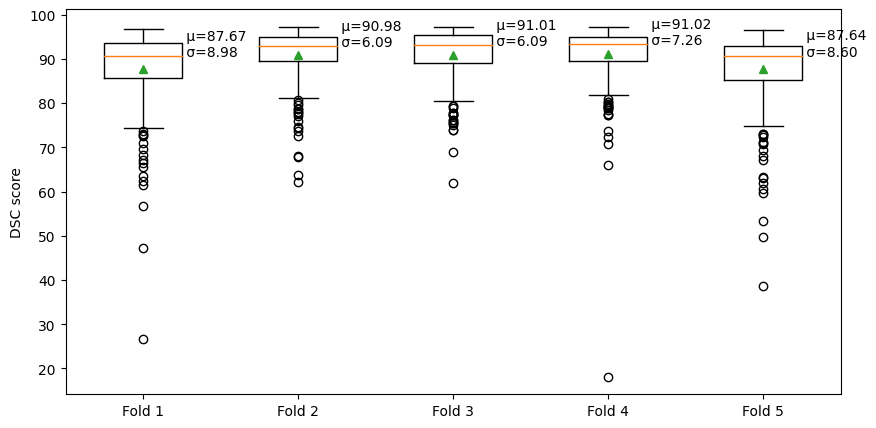

In [ ]:
print(dsc_scores)
#score_mat = np.transpose(np.asarray(dsc_scores, dtype=object))[0]
#print(score_mat.shape)
plot_scores_per_region(0,metric='DSC')

Core  tumor
plotting scores for the dice
shape score mat 230


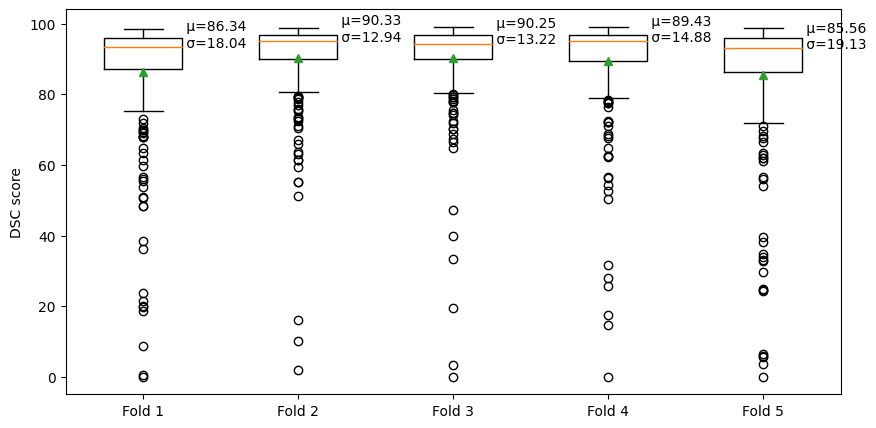

In [ ]:
plot_scores_per_region(1,metric='DSC')

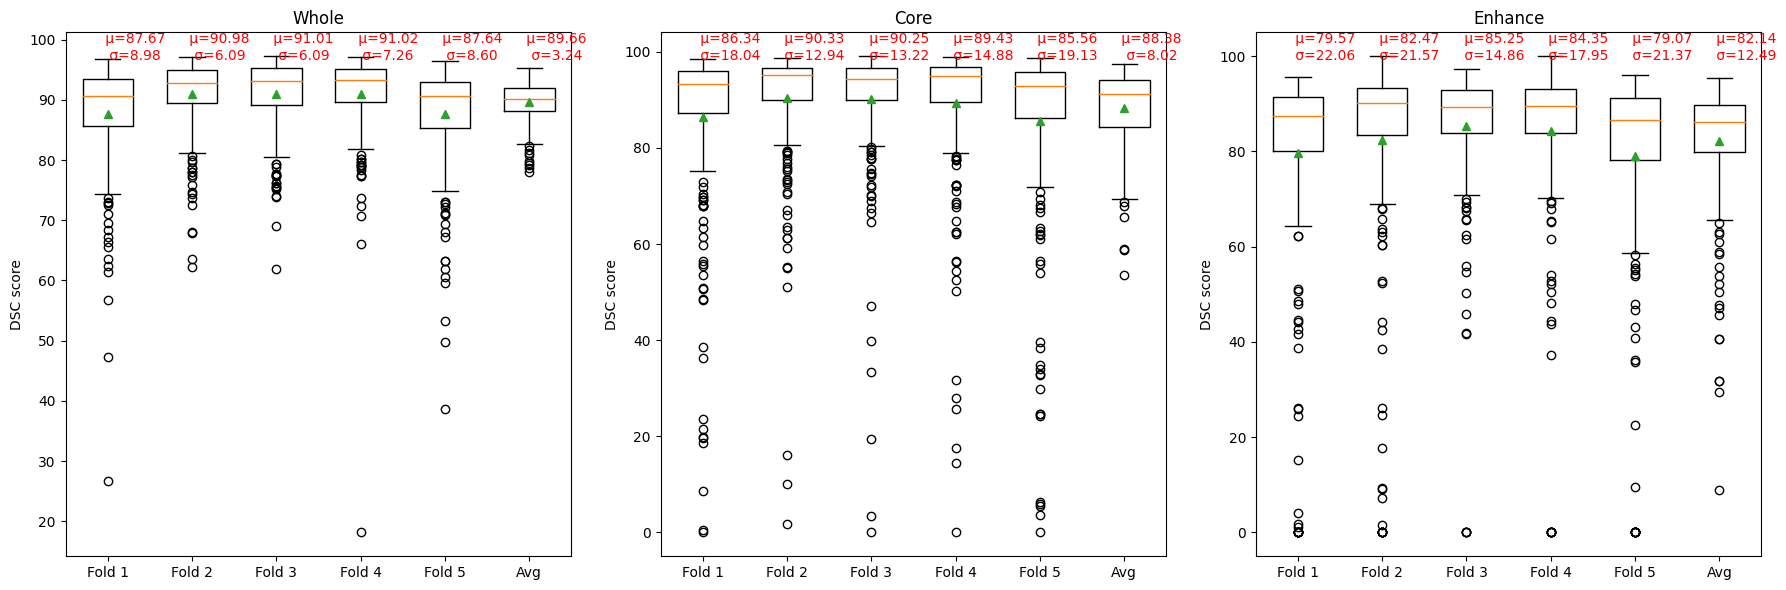

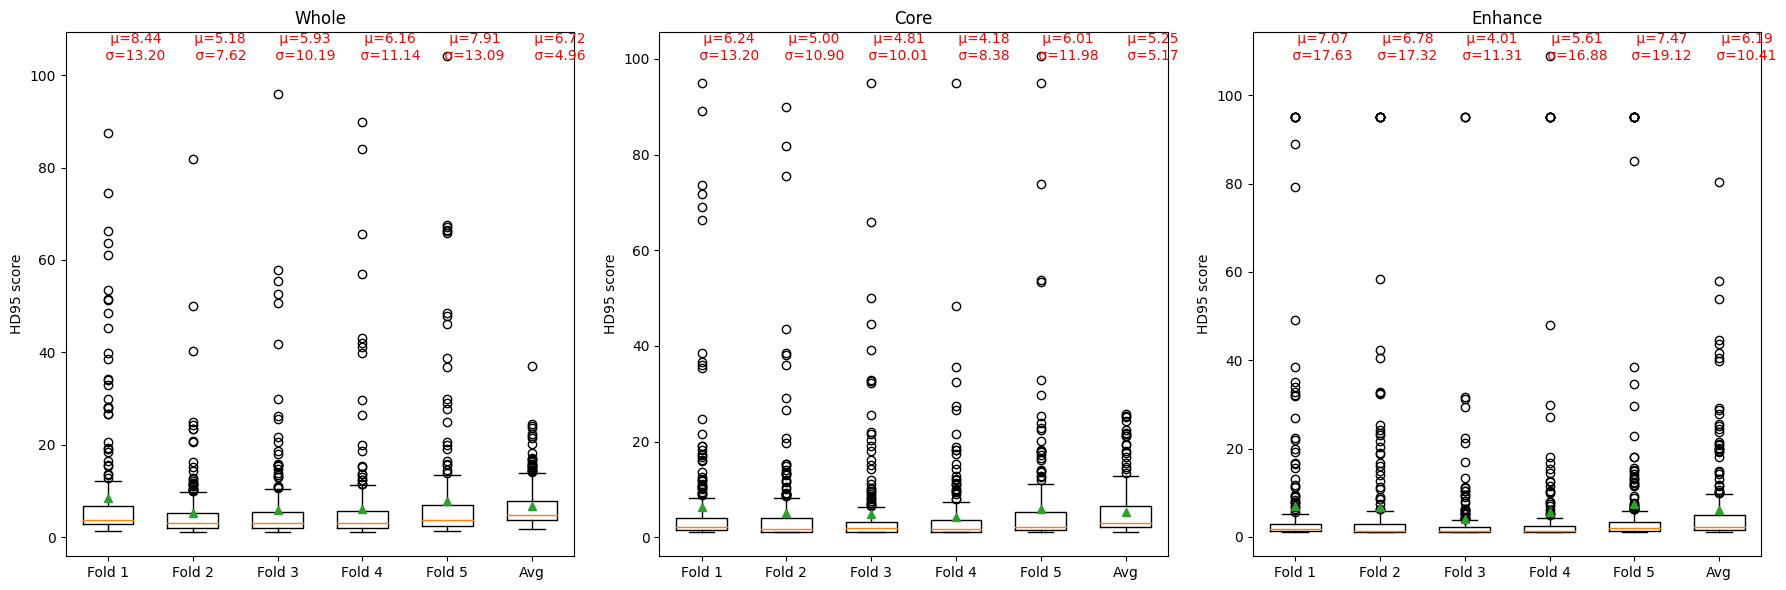

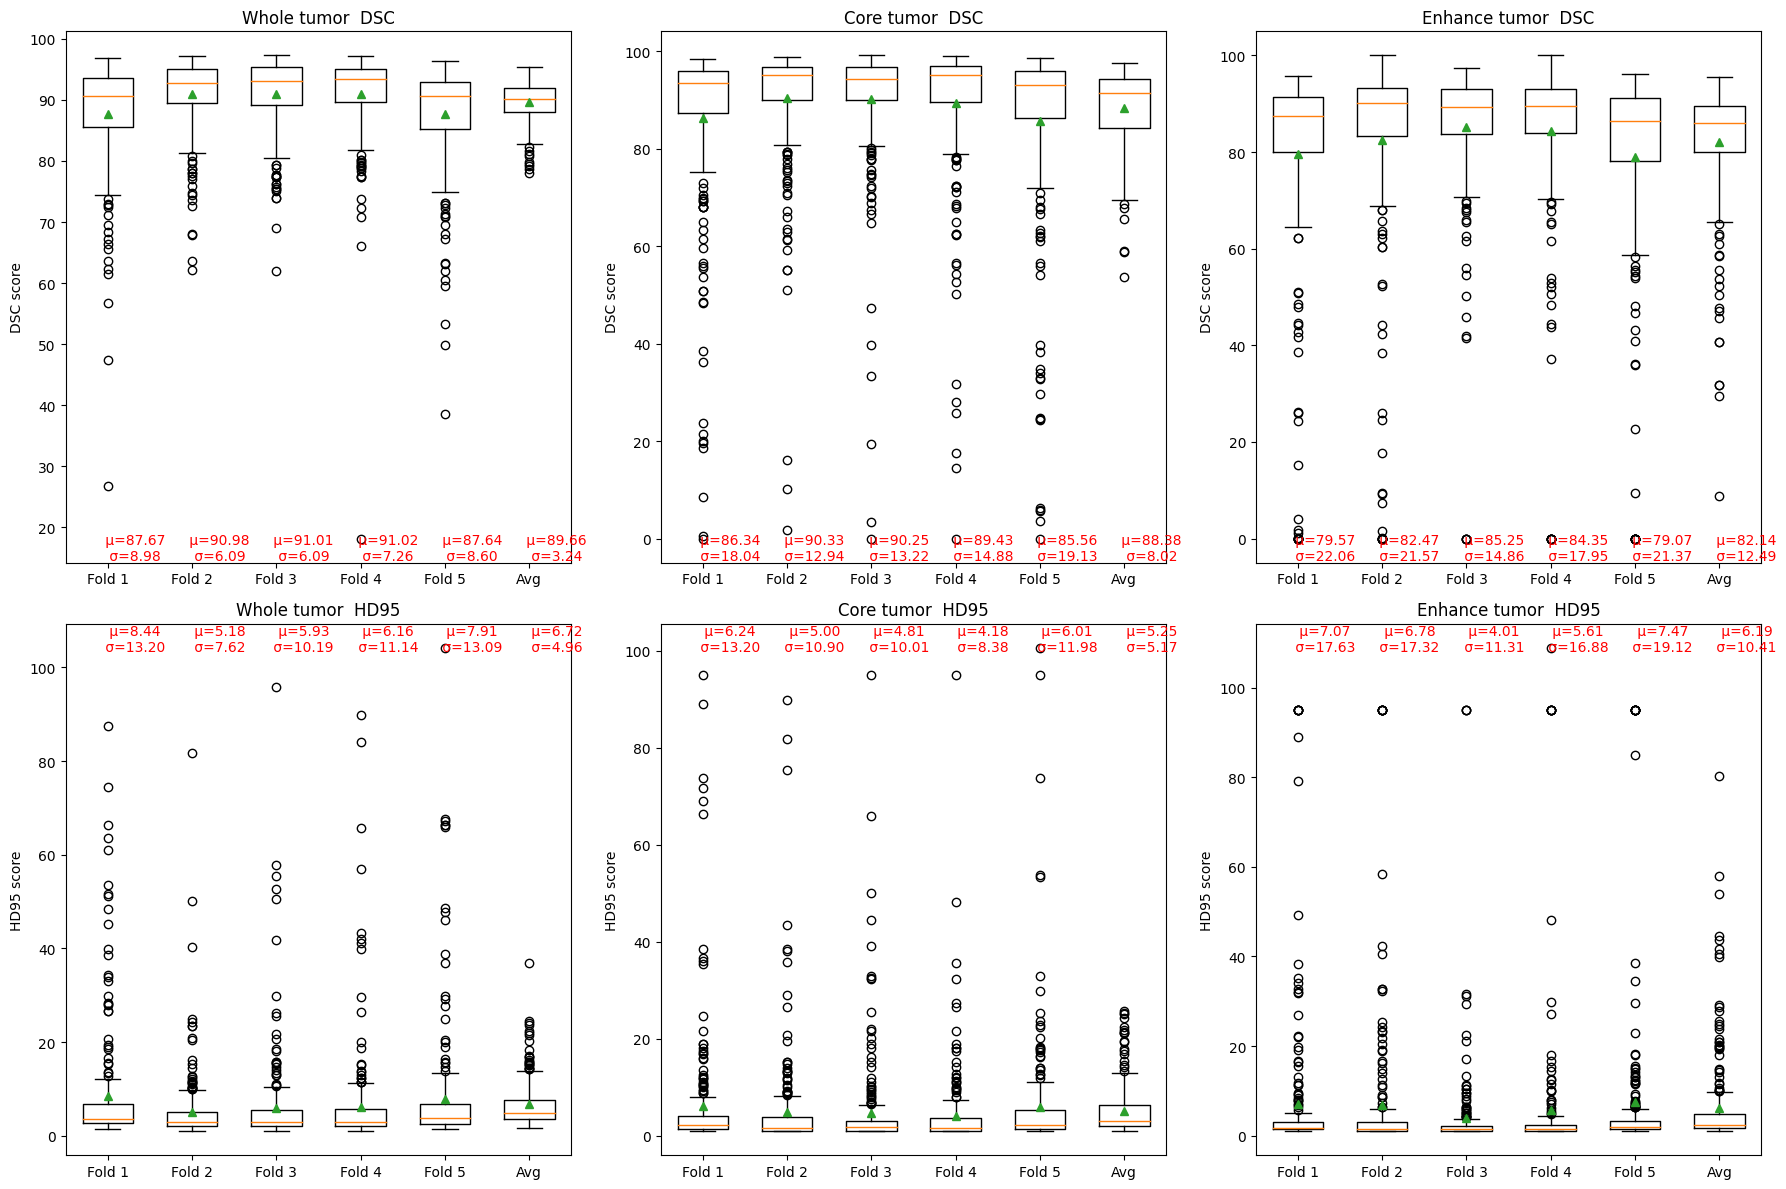

In [ ]:
import numpy as np
import pickle
from matplotlib import pyplot as plt
import copy

# Load the pickle files
with open('dscs2021_paper1.pkl', 'rb') as f:
    dsc_scores = pickle.load(f)
with open('hds2021_paper1.pkl', 'rb') as f:
    hd95_scores = pickle.load(f)

def plot_scores(scores, metric):
    domains = ['Whole', 'Core', 'Enhance']
    fig, ax = plt.subplots(1, 3, figsize=(18, 6))  # 1 row, 3 columns

    for k, domain in enumerate(domains):
        Z = np.transpose(np.asarray(scores))[0][k]
        score_mat = Z
        avg = np.mean(score_mat, axis=1)
        avg = avg.reshape(score_mat.shape[0], 1)
        score_mat = np.append(score_mat, avg, axis=1)
        m1 = score_mat.mean(axis=0)
        st1 = score_mat.std(axis=0)
        position = np.arange(6) + 1  # To separate different folds

        bp = ax[k].boxplot(score_mat, positions=position, widths=0.6, showmeans=True, vert=True, patch_artist=False)
        ax[k].set_title(domain)
        ax[k].set_xticks([1, 2, 3, 4, 5, 6])
        ax[k].set_xticklabels(['Fold 1', 'Fold 2', 'Fold 3', 'Fold 4', 'Fold 5', 'Avg'])
        for i, line in enumerate(bp['medians']):
            x, y = line.get_xydata()[1]
            text = ' μ={:.2f}\n σ={:.2f}'.format(m1[i], st1[i])
            text_y = ax[k].get_ylim()[0] if metric == 'dice' else ax[k].get_ylim()[1]
            ax[k].annotate(text, xy=(x, text_y), color='red', ha='center', va='bottom' if metric == 'dice' else 'top')  # set the color to red, align text at the bottom for 'dice' and at the top for 'hd95'

        ax[k].set_ylabel(metric + ' score')

    plt.tight_layout()
    plt.show()

# Step 1: Plot dice scores
plot_scores(dsc_scores, 'DSC')

# Step 2: Plot hd95 scores
plot_scores(hd95_scores, 'HD95')

# Step 3: Plot both metrics
fig, ax = plt.subplots(2, 3, figsize=(18, 12))  # 2 rows (for two metrics), 3 columns (for domains)

def plot_scores_together(scores, metric, row):
    domains = ['Whole tumor', 'Core tumor', 'Enhance tumor']

    for k, domain in enumerate(domains):
        Z = np.transpose(np.asarray(scores))[0][k]
        score_mat = Z
        avg = np.mean(score_mat, axis=1)
        avg = avg.reshape(score_mat.shape[0], 1)
        score_mat = np.append(score_mat, avg, axis=1)
        m1 = score_mat.mean(axis=0)
        st1 = score_mat.std(axis=0)
        position = np.arange(6) + 1  # To separate different folds

        bp = ax[row][k].boxplot(score_mat, positions=position, widths=0.6, showmeans=True, vert=True, patch_artist=False)
        ax[row][k].set_title(domain + '  ' + metric)
        ax[row][k].set_xticks([1, 2, 3, 4, 5, 6])
        ax[row][k].set_xticklabels(['Fold 1', 'Fold 2', 'Fold 3', 'Fold 4', 'Fold 5', 'Avg'])
        for i, line in enumerate(bp['medians']):
            x, y = line.get_xydata()[1]
            text = ' μ={:.2f}\n σ={:.2f}'.format(m1[i], st1[i])
            text_y = ax[row][k].get_ylim()[0] if metric == 'DSC' else ax[row][k].get_ylim()[1]
            ax[row][k].annotate(text, xy=(x, text_y), color='red', ha='center', va='bottom' if metric == 'DSC' else 'top')  # set the color to red, align text at the bottom for 'dice' and at the top for 'hd95'

        ax[row][k].set_ylabel(metric + ' score')

plot_scores_together(dsc_scores, 'DSC', 0)  # Plotting 'dice' scores in the first row
plot_scores_together(hd95_scores, 'HD95', 1)  # Plotting 'hd95' scores in the second row
plt.tight_layout()
plt.show()

In [ ]:
def make_gradcam_heatmap(img_array, model, layer_name, class_idx):
    grad_model = tf.keras.models.Model(
        [model.inputs], [model.get_layer(layer_name).output, model.output]
    )

    with tf.GradientTape() as tape:
        conv_outputs, predictions = grad_model(img_array)
        loss = predictions[0, :, :, :, class_idx]

    grads = tape.gradient(loss, conv_outputs)
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))

    conv_outputs = conv_outputs[0]
    heatmap = conv_outputs @ pooled_grads[..., tf.newaxis]
    heatmap = tf.squeeze(heatmap)

    heatmap = tf.maximum(heatmap, 0) / tf.math.reduce_max(heatmap)
    return heatmap.numpy()

In [ ]:
import cv2
import numpy as np
def make_gradcam_heatmapmine(img_array, model, layer_name, class_idx):
    grad_model = tf.keras.models.Model(
        [model.inputs], [model.get_layer(layer_name).output, model.output]
    )

    with tf.GradientTape() as tape:
        conv_outputs, predictions = grad_model(img_array)
        loss = predictions[0, :, :, :, class_idx]

   # grads = tape.gradient(loss, conv_outputs)
    output = conv_outputs[0]
   # print(output.shape,len(output))
    grads = tape.gradient(loss, conv_outputs)[0]
    gate_f = tf.cast(output > 0, 'float32')
    gate_r = tf.cast(grads > 0, 'float32')
    guided_grads = tf.cast(output > 0, 'float32') * tf.cast(grads > 0, 'float32') * grads

    weights = tf.reduce_mean(guided_grads, axis=(0, 1,2))
   # print(len(weights))
    cam = np.ones(output.shape[0: 3], dtype = np.float32)
   # print(cam.shape)
    for i, w in enumerate(weights):
        #print(w)
        cam += w * output[:, :, :, i]
    heatmap=cam
    heatmap = tf.maximum(heatmap, 0) / tf.math.reduce_max(heatmap)
    return heatmap#heatmap.numpy()

In [ ]:
def visualise_attention_per_model(image,mask,prediction,attention_heatmaps,layer_index):
    fig, axs = plt.subplots(3, len(attention_heatmaps[0])+3, figsize=(14,10))
    model_names=['Attention', 'No Attention']
    class_names=['Background','(NCR/NET)','(ED)','(ET)']
    for k in range(0,2):
      heatmap_3clsses=np.zeros(attention_heatmaps[k][0][layer_index].shape[0:2])
      for class_idx in range(len(attention_heatmaps[0])):
         # selected_slice = int(attention_heatmaps[k][class_idx][layer_index].shape[2]/2)
          selected_slice = 80
          # First display the image slice
          axs[k,class_idx].imshow(image[0, :, :, selected_slice, 0], cmap='gray')
          # Then overlay the heatmap, using a suitable alpha
          axs[k,class_idx].imshow(attention_heatmaps[k][class_idx][layer_index][:, :, selected_slice], cmap='hot', alpha=0.5)
          axs[k,class_idx].set_title(f'{class_names[class_idx]}')
          heatmap_3clsses=heatmap_3clsses+attention_heatmaps[k][class_idx][layer_index][:, :, selected_slice]
      axs[k,class_idx+1].imshow(mask[:, :, selected_slice])
      axs[k,class_idx+1].set_title('Ground Truth')
      axs[k,class_idx+2].imshow(prediction[k][:, :, selected_slice])
      axs[k,class_idx+2].set_title('Prediction')
      axs[k,class_idx+3].imshow(heatmap_3clsses)
      axs[k,class_idx+3].set_title(model_names[k])
    plt.show()




In [ ]:
def get_heatmap_layers(image,my_model,list_layers,class_idx):
  features_layer=[]
  for i, layer_name in enumerate(list_layers):
      heatmap = make_gradcam_heatmapmine(image, my_model, layer_name, class_idx)
      features_layer.append(heatmap)
  return features_layer


In [ ]:
from matplotlib import colors
import numpy as np
import matplotlib.pyplot as plt

def visualise_attention_per_model(image, mask, prediction, attention_heatmaps, layer_index):
    # Change here: 2 rows instead of 3
    fig, axs = plt.subplots(2, len(attention_heatmaps[0])+3, figsize=(14, 10))

    model_names = ['Attention', 'No Attention']
    class_names = ['Background', '(NCR/NET)', '(ED)', '(ET)']

    # Custom colormap
    cmap = colors.ListedColormap(['blue', 'green', 'red'])
    norm = colors.BoundaryNorm([0.5, 1.5, 2.5, 4.5], cmap.N)

    for k in range(2):
        heatmap_3classes = np.zeros(attention_heatmaps[k][0][layer_index].shape[:2])
        for class_idx in range(len(attention_heatmaps[0])):
            selected_slice = 80
            # First display the image slice
            axs[k, class_idx].imshow(image[0, :, :, selected_slice, 0], cmap='gray')
            # Then overlay the heatmap
            axs[k, class_idx].imshow(attention_heatmaps[k][class_idx][layer_index][:, :, selected_slice], cmap='hot', alpha=0.5)
            axs[k, class_idx].set_title(f'{class_names[class_idx]}')

            heatmap_3classes += attention_heatmaps[k][class_idx][layer_index][:, :, selected_slice]

        # Adjustments for the indexing of Ground Truth and Prediction plots
        axs[k, len(attention_heatmaps[0])].imshow(image[0, :, :, selected_slice, 0], cmap='gray')
        masked_mask = np.ma.masked_where(mask[:, :, selected_slice] == 0, mask[:, :, selected_slice])
        axs[k, len(attention_heatmaps[0])].imshow(masked_mask, cmap='jet', alpha=0.5)
        axs[k, len(attention_heatmaps[0])].set_title('Ground Truth')

        axs[k, len(attention_heatmaps[0])+1].imshow(image[0, :, :, selected_slice, 0], cmap='gray')
        masked_prediction = np.ma.masked_where(prediction[k][:, :, selected_slice] == 0, prediction[k][:, :, selected_slice])
        axs[k, len(attention_heatmaps[0])+1].imshow(masked_prediction, cmap='jet', alpha=0.5)
        axs[k, len(attention_heatmaps[0])+1].set_title('Prediction')

        # Plotting the combined heatmap
        axs[k, len(attention_heatmaps[0])+2].imshow(heatmap_3classes, cmap='hot', alpha=0.5)
        axs[k, len(attention_heatmaps[0])+2].set_title(model_names[k])

    plt.tight_layout()
    plt.show()

In [ ]:
images_path="/content/drive/MyDrive/Bratsdataset/BraTs2020/fold_0/val/"
val_list=os.listdir(images_path)
image_names=os.listdir(images_path)

In [ ]:
from keras.models import load_model

my_model = load_model('/content/drive/MyDrive/AttentionDice.hdf5', compile=False)
my_modelno = load_model('/content/drive/MyDrive/NoAttentionDice.hdf5', compile=False)
my_modelwdl = load_model('/content/drive/MyDrive/AttentionWDL.hdf5', compile=False)



(128, 128, 128)
[0. 1. 2. 3.]


1/1 [==============================] - 3s 3s/step


1/1 [==============================] - 3s 3s/step
shape (1, 128, 128, 128, 4)
shape (128, 128, 128)


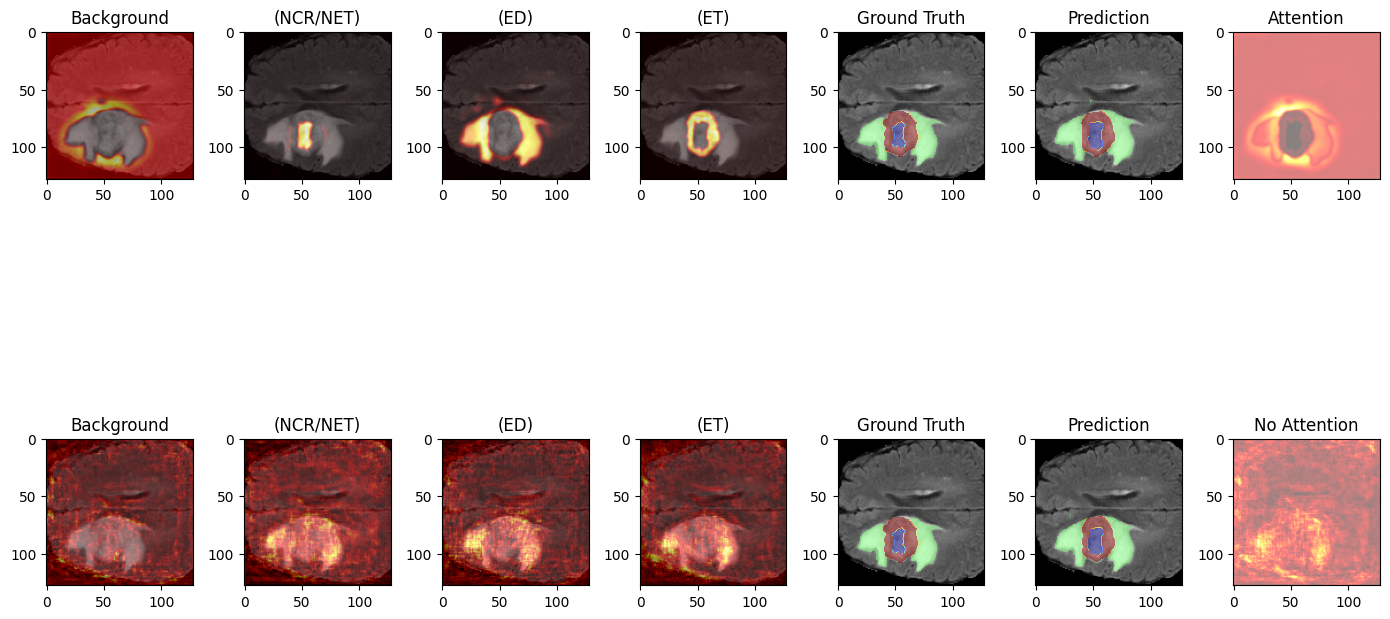

In [ ]:
for i, dir_name in enumerate(image_names[:1]):
#173
    image = np.load(images_path +'train173/image_173.npy')#[0]
    mask  = np.load(images_path +'train173/mask_173.npy')#[0]
    print(mask.shape)
    print(np.unique(mask))
    image = np.expand_dims(image,0)#

    prediction = my_model.predict(image)
    prediction_mask = np.argmax(prediction, axis=-1)[0,:,:,:]

    layers=['layer_1','upsample_layer_3_conv2','layer_8_concatenate','layer_9','layer_18_maxpool','upsample_layer_1_conv']#,'upsample_layer_2_conv1','upsample_layer_2_dropout','upsample_layer_3_conv1','upsample_layer_2_dropout']
    attention_heatmap_per_class=[]
    for class_idx in range(prediction.shape[-1]):
        H=get_heatmap_layers(image,my_model,layers,class_idx)
        attention_heatmap_per_class.append(H)

    predictionold = my_modelno.predict(image)
    print('shape', predictionold.shape)
    predictionold_mask = np.argmax(predictionold, axis=-1)[0,:,:,:]
    print('shape', predictionold_mask.shape)
    layers=['layer_1','upsample_layer_3_conv2','layer_8_concatenate','layer_9','layer_18_maxpool','upsample_layer_1_conv']
    noattention_heatmap_per_class=[]
    for class_idx in range(predictionold.shape[-1]):
        H=get_heatmap_layers(image,modelno,layers,class_idx)
        noattention_heatmap_per_class.append(H)
    visualise_attention_per_model(image,mask,[prediction_mask,predictionold_mask],[attention_heatmap_per_class,noattention_heatmap_per_class],1)

(128, 128, 128)
[0. 1. 2. 3.]
1/1 [==============================] - 3s 3s/step
shape (1, 128, 128, 128, 4)
shape (128, 128, 128)


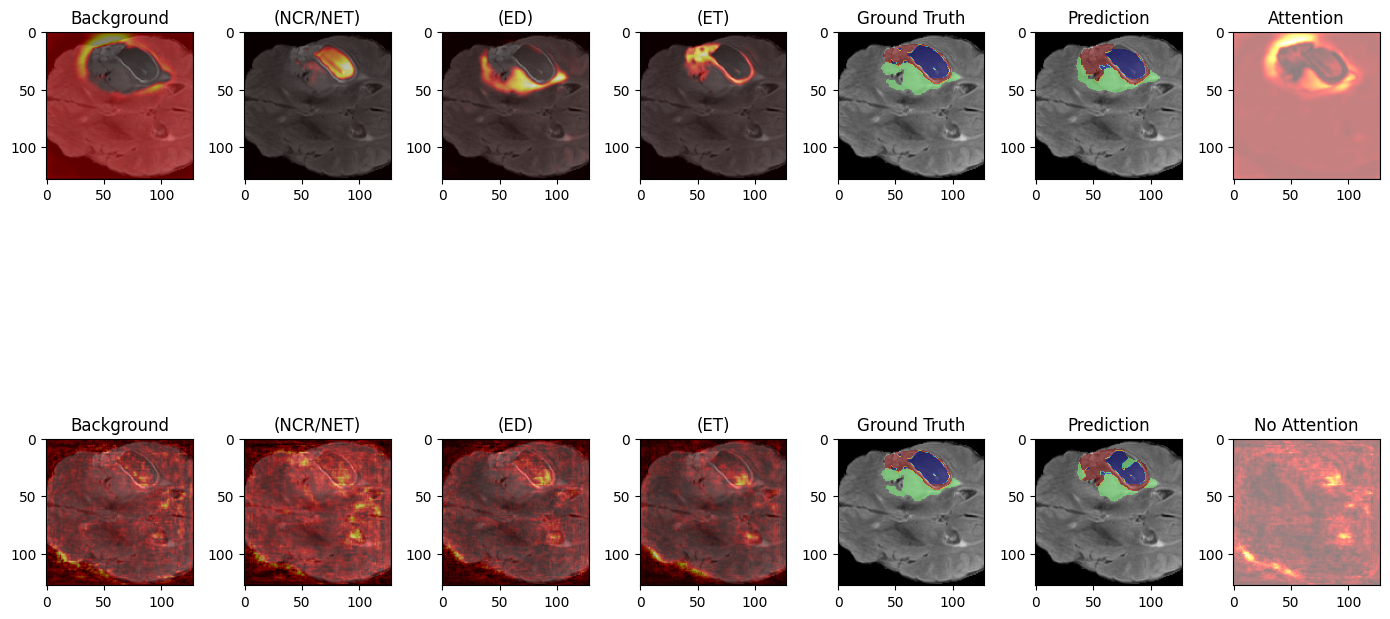

In [ ]:
for i, dir_name in enumerate(image_names[:1]):

    image = np.load(images_path +'train356/image_356.npy')#[0]
    mask  = np.load(images_path +'train356/mask_356.npy')#[0]
    print(mask.shape)
    print(np.unique(mask))
    image = np.expand_dims(image,0)#

    prediction = my_model.predict(image)
    prediction_mask = np.argmax(prediction, axis=-1)[0,:,:,:]

    layers=['layer_1','upsample_layer_3_conv2','layer_8_concatenate','layer_9','layer_18_maxpool','upsample_layer_1_conv']#,'upsample_layer_2_conv1','upsample_layer_2_dropout','upsample_layer_3_conv1','upsample_layer_2_dropout']
    attention_heatmap_per_class=[]
    for class_idx in range(prediction.shape[-1]):
        H=get_heatmap_layers(image,my_model,layers,class_idx)
        attention_heatmap_per_class.append(H)

    predictionold = my_modelno.predict(image)
    print('shape', predictionold.shape)
    predictionold_mask = np.argmax(predictionold, axis=-1)[0,:,:,:]
    print('shape', predictionold_mask.shape)
    layers=['layer_1','upsample_layer_3_conv2','layer_8_concatenate','layer_9','layer_18_maxpool','upsample_layer_1_conv']
    noattention_heatmap_per_class=[]
    for class_idx in range(predictionold.shape[-1]):
        H=get_heatmap_layers(image,modelno,layers,class_idx)
        noattention_heatmap_per_class.append(H)
    visualise_attention_per_model(image,mask,[prediction_mask,predictionold_mask],[attention_heatmap_per_class,noattention_heatmap_per_class],1)

(128, 128, 128)
[0. 1. 2. 3.]
1/1 [==============================] - 2s 2s/step
shape (1, 128, 128, 128, 4)
shape (128, 128, 128)


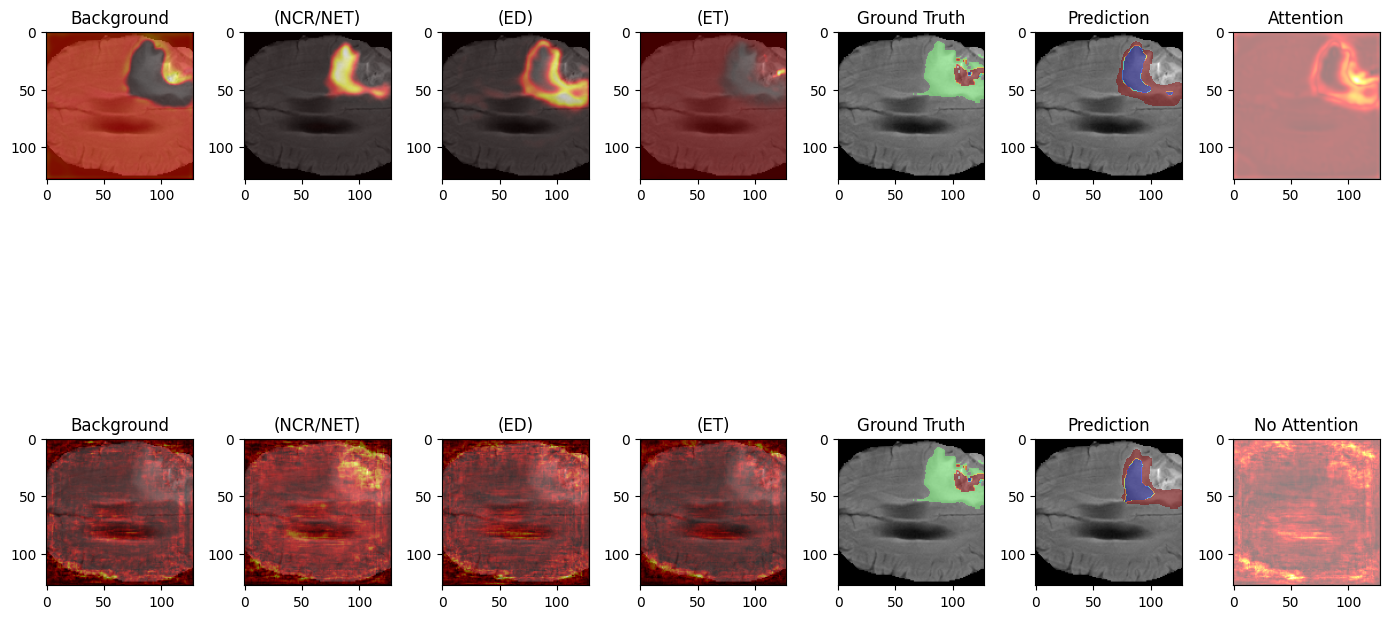

In [ ]:
for i, dir_name in enumerate(image_names[:1]):

    image = np.load(images_path +'train235/image_235.npy')#[0]
    mask  = np.load(images_path +'train235/mask_235.npy')#[0]
    print(mask.shape)
    print(np.unique(mask))
    image = np.expand_dims(image,0)#

    prediction = my_model.predict(image)
    prediction_mask = np.argmax(prediction, axis=-1)[0,:,:,:]

    layers=['layer_1','upsample_layer_3_conv2','layer_8_concatenate','layer_9','layer_18_maxpool','upsample_layer_1_conv']#,'upsample_layer_2_conv1','upsample_layer_2_dropout','upsample_layer_3_conv1','upsample_layer_2_dropout']
    attention_heatmap_per_class=[]
    for class_idx in range(prediction.shape[-1]):
        H=get_heatmap_layers(image,my_model,layers,class_idx)
        attention_heatmap_per_class.append(H)

    predictionold = my_modelno.predict(image)
    print('shape', predictionold.shape)
    predictionold_mask = np.argmax(predictionold, axis=-1)[0,:,:,:]
    print('shape', predictionold_mask.shape)
    layers=['layer_1','upsample_layer_3_conv2','layer_8_concatenate','layer_9','layer_18_maxpool','upsample_layer_1_conv']
    noattention_heatmap_per_class=[]
    for class_idx in range(predictionold.shape[-1]):
        H=get_heatmap_layers(image,modelno,layers,class_idx)
        noattention_heatmap_per_class.append(H)
    visualise_attention_per_model(image,mask,[prediction_mask,predictionold_mask],[attention_heatmap_per_class,noattention_heatmap_per_class],1)

In [42]:
import numpy as np
import os
import glob
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
from keras.models import load_model

def plot_confusion_matrix(y_true, y_pred):
    y_true = np.reshape(y_true, -1)
    y_pred = np.reshape(y_pred, -1)
    cm = confusion_matrix(y_true, y_pred)
    return cm

def get_con_matrix_all_sklrn(best_model, images_dir_path, class_names=['Background', '(NCR/NET)', '(ED)', '(ET)']):
    et_class_index = class_names.index('(ET)')
    aggregated_cm = np.zeros([len(class_names), len(class_names)])
    conf_matrices_all = []
    image_names_list = os.listdir(images_dir_path)

    for dir_name in image_names_list:
        image_files = glob.glob(os.path.join(images_dir_path, dir_name, 'image_*.npy'))
        mask_files = glob.glob(os.path.join(images_dir_path, dir_name, 'mask_*.npy'))

        if not image_files or not mask_files:
            continue

        image = np.load(image_files[0])
        mask = np.load(mask_files[0])
        image = np.expand_dims(image, 0)
        prediction = best_model.predict(image)
        prediction_mask = np.argmax(prediction, axis=-1)[0, :, :, :]

        cm = plot_confusion_matrix(mask, prediction_mask)

        # Include this matrix only if 'ET' class is present in ground truth or predictions
        if et_class_index in np.unique(mask):
            conf_matrices_all.append(cm)
            aggregated_cm += cm

    return aggregated_cm, conf_matrices_all

def calculate_mean_std(matrices):
    normalized_matrices = []

    for cm in matrices:
        row_sums = cm.sum(axis=1)[:, np.newaxis]
        normalized_cm = cm.astype('float') / (row_sums + 1e-10)
        normalized_matrices.append(normalized_cm)

    normalized_matrices_array = np.array(normalized_matrices)
    mean_matrix = np.mean(normalized_matrices_array, axis=0)
    std_matrix = np.std(normalized_matrices_array, axis=0)

    return mean_matrix, std_matrix

In [43]:
images_path = "/content/drive/MyDrive/Bratsdataset/fold_0/val/"
cf_matrix_sklrn, all_conf_mat = get_con_matrix_all_sklrn(my_modelwdl, images_path)

1/1 [==============================] - 0s 34ms/step


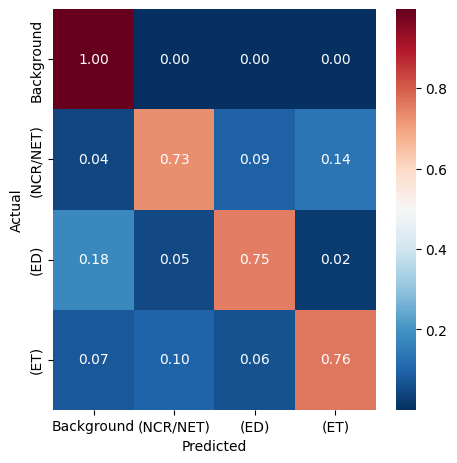

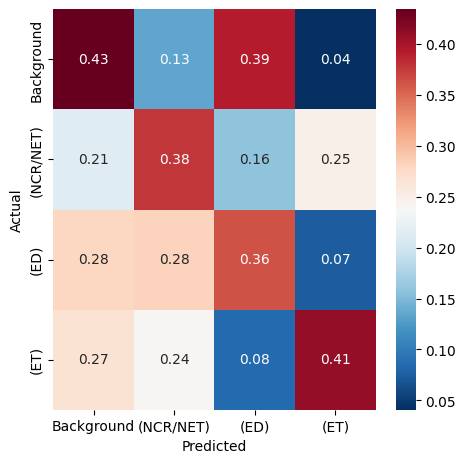

In [44]:
# Compute the mean and std from individual normalized matrices
mn, std = calculate_mean_std(all_conf_mat)

# Normalize the mean and std matrices
row_sums_mean = mn.sum(axis=1)[:, np.newaxis]
mn_normalized = mn.astype('float') / (row_sums_mean + 1e-10)

row_sums_std = std.sum(axis=1)[:, np.newaxis]
std_normalized = std.astype('float') / (row_sums_std + 1e-10)

# Plotting
class_names = ['Background', '(NCR/NET)', '(ED)', '(ET)']
fig, ax = plt.subplots(figsize=(len(class_names) * 1.3, len(class_names) * 1.3))
sns.heatmap(mn_normalized, annot=True, fmt=".2f", cmap="RdBu_r", xticklabels=class_names, yticklabels=class_names)
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()

fig, ax = plt.subplots(figsize=(len(class_names) * 1.3, len(class_names) * 1.3))
sns.heatmap(std_normalized, annot=True, fmt=".2f", cmap="RdBu_r", xticklabels=class_names, yticklabels=class_names)
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()